In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

og file's copy that is for handmade train test split


In [1]:
import pandas as pd

path = r"C:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\reroute, more samples\merged_df_bigger_sample.csv"
df = pd.read_csv(path)
df.columns = df.columns.str.lower()


# optionally turn it into net sc only 
#df = df [ df ['net_sc'] != 0].copy()

#separating into old positives, new positives and all negatives nb: would be better to mark also the older/ newer negatives maybe later
new_positives = df[ (df['old'] == 0) & (df['grosscontractsigned']== 1)].reset_index(drop=True)
old_positives =  df[df['old']==1].reset_index(drop=True)
rest_negatives = df[ df[ 'grosscontractsigned'] == 0].reset_index(drop=True)

negative_train = rest_negatives.sample(frac=0.7, random_state=42)
negative_test = rest_negatives.drop(negative_train.index)

# these is 4184. to keep the original ratio i have to add 210 new positives
test_new_positives = new_positives.sample(n=244, random_state = 42)
train_new_positives = new_positives.drop(test_new_positives.index)

# create final train and test
train = pd.concat( [negative_train, train_new_positives, old_positives])
test = pd.concat ( [test_new_positives, negative_test])

# boo dont forget to drop old mark
train = train.drop('old', axis=1)
test = test.drop('old', axis=1)

# for some reason selfipadone is missing on a few columns, later look but for now fill with 0 
train['selfipa_done'] = train['selfipa_done'].fillna(0)
test['selfipa_done'] = test['selfipa_done'].fillna(0)

#split 
X_train = train.drop('grosscontractsigned', axis=1)
y_train = train['grosscontractsigned']
X_test = test.drop('grosscontractsigned', axis=1)
y_test = test['grosscontractsigned']


<class 'pandas.core.frame.DataFrame'>
Index: 18431 entries, 9658 to 1681
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gross_fu                        18431 non-null  int64  
 1   gross_sc                        18431 non-null  int64  
 2   net_fu                          18431 non-null  float64
 3   net_sc                          18431 non-null  float64
 4   time_first_sc_to_first_net_fu   18431 non-null  float64
 5   electricitybill                 18431 non-null  float64
 6   heatingbill                     18431 non-null  float64
 7   grosscontractsigned             18431 non-null  float64
 8   selfipa_done                    18431 non-null  float64
 9   zipregion_missing               18431 non-null  int64  
 10  evaluationtime_missing          18431 non-null  int64  
 11  desiredinstallationend_missing  18431 non-null  int64  
 12  electricitybill_missing         184

In [55]:
df2['grosscontractsigned'].value_counts()

grosscontractsigned
0.0    10109
1.0      590
Name: count, dtype: int64

# first attempt

on thursday i worked on this with dataset that has older examples too. this and the very last bit (confirming no signam) and see the ranking dashboard (our main goal)

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class TwoStageContractPredictor:
    """
    A two-stage model to predict contract signing while handling temporal leakage
    and class imbalance.
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.stage1_model = None
        self.stage2_model = None
        self.stage1_scaler = StandardScaler()
        self.stage2_scaler = StandardScaler()
        self.stage1_features = None
        self.stage2_features = None

    def identify_feature_stages(self, df):
        df.columns = df.columns.str.lower()

        stage1_features = [
            'electricitybill', 'heatingbill',
            'selfipa_done', 'zipregion_missing',
            'evaluationtime_missing', 'desiredinstallationend_missing',
            'electricitybill_missing', 'heatingbill_missing',
            'mktgparamscore_missing', 'desiredinstallationend_encoded',
            'mktg_high', 'mktg_low', 'mktg_medium',
            'region_high_performer', 'region_large_good',
            'region_medium', 'region_other',
            'total_bc_attempts', 'total_bc_outcomes',
            'lead_to_first_bc_days', 'bc_duration_days',
            'bc_frequency', 'positive_outcomes_count',
            'negative_outcomes_count', 'noshow_outcomes_count',
            'positive_outcome_ratio', 'negative_outcome_ratio',
            'noshow_outcome_ratio', 'reachability_score',
            'outcome_trend', 'persistence_after_negative',
            'engagement_score', 'efficiency_score',
            'last_bc_outcome_encoded', 'first_bc_outcome_encoded'
        ]

        stage2_features = stage1_features + [
            'gross_fu', 'gross_sc', 'net_fu', 'net_sc',
            'time_first_sc_to_first_net_fu'
        ]

        self.stage1_features = [f for f in stage1_features if f in df.columns]
        self.stage2_features = [f for f in stage2_features if f in df.columns]
        return self.stage1_features, self.stage2_features

    def create_stage_labels(self, df):
        df.columns = df.columns.str.lower()
        stage1_label = (df['net_sc'] > 0).astype(int) if 'net_sc' in df.columns else pd.Series(0, index=df.index)
        stage2_label = df['grosscontractsigned']
        return stage1_label, stage2_label

    def build_neural_network(self, input_dim, name="model"):
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(1, activation='sigmoid')
        ], name=name)
        return model

    def handle_imbalance(self, X, y, strategy='hybrid'):
        if strategy == 'smote':
            smote = SMOTE(random_state=self.random_state)
            X_res, y_res = smote.fit_resample(X, y)
        elif strategy == 'undersample':
            rus = RandomUnderSampler(random_state=self.random_state)
            X_res, y_res = rus.fit_resample(X, y)
        elif strategy == 'hybrid':
            unique, counts = np.unique(y, return_counts=True)
            if len(counts) < 2:
                X_res, y_res = X, y
            else:
                minority_count = min(counts)
                majority_count = max(counts)
                current_ratio = minority_count / majority_count
                smote_ratio = min(0.3, current_ratio * 3)
                final_ratio = min(0.6, current_ratio * 5)
                try:
                    pipeline = ImbPipeline([
                        ('smote', SMOTE(sampling_strategy=smote_ratio, random_state=self.random_state)),
                        ('undersample', RandomUnderSampler(sampling_strategy=final_ratio, random_state=self.random_state))
                    ])
                    X_res, y_res = pipeline.fit_resample(X, y)
                except ValueError:
                    smote = SMOTE(sampling_strategy=min(0.3, current_ratio * 2), random_state=self.random_state)
                    X_res, y_res = smote.fit_resample(X, y)
            return X_res, y_res
        return X, y

    def train_stage1(self, X_train, y_train, epochs=50):
        print("Training Stage 1...")
        X_train_scaled = self.stage1_scaler.fit_transform(X_train)
        self.stage1_model = self.build_neural_network(X_train_scaled.shape[1], name="stage1")
        class_weight = {0: 1., 1: 3.}
        self.stage1_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='auc', patience=10, restore_best_weights=True, mode='max')
        self.stage1_model.fit(
            X_train_scaled, y_train,
            epochs=epochs, batch_size=32,
            class_weight=class_weight,
            callbacks=[early_stop], verbose=0
        )

    def train_stage2(self, X_train, y_train, epochs=50):
        print("Training Stage 2...")
        X_train_scaled = self.stage2_scaler.fit_transform(X_train)
        self.stage2_model = self.build_neural_network(X_train_scaled.shape[1], name="stage2")
        self.stage2_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='auc', patience=10, restore_best_weights=True, mode='max')
        self.stage2_model.fit(
            X_train_scaled, y_train,
            epochs=epochs, batch_size=32,
            callbacks=[early_stop], verbose=0
        )

    def fit(self, train_df, epochs_stage1=50, epochs_stage2=50):
        self.identify_feature_stages(train_df)
        stage1_label, stage2_label = self.create_stage_labels(train_df)

        # --- Stage 1 ---
        X_stage1 = train_df[self.stage1_features]
        y_stage1 = stage1_label
        self.train_stage1(X_stage1, y_stage1, epochs_stage1)

        # --- Stage 2 ---
        stage2_mask = stage1_label == 1
        X_stage2 = train_df.loc[stage2_mask, self.stage2_features]
        y_stage2 = stage2_label[stage2_mask]

        if len(X_stage2) == 0 or y_stage2.nunique() < 2:
            print("⚠️ Skipping Stage 2 training (no SC leads or only one class).")
            self.stage2_model = None
            return

        self.train_stage2(X_stage2, y_stage2, epochs_stage2)

    def predict_proba(self, df):
        X_stage1_scaled = self.stage1_scaler.transform(df[self.stage1_features])
        p_sc = self.stage1_model.predict(X_stage1_scaled, verbose=0).ravel()

        if self.stage2_model is None:
            return {
                'p_sc': p_sc,
                'p_contract_given_sc': np.zeros_like(p_sc),
                'p_contract': p_sc
            }

        X_stage2_scaled = self.stage2_scaler.transform(df[self.stage2_features])
        p_contract_given_sc = self.stage2_model.predict(X_stage2_scaled, verbose=0).ravel()
        p_contract = p_sc * p_contract_given_sc

        return {
            'p_sc': p_sc,
            'p_contract_given_sc': p_contract_given_sc,
            'p_contract': p_contract
        }

    def evaluate(self, test_df):
        predictions = self.predict_proba(test_df)
        y_true = test_df['grosscontractsigned']
        auc_score = roc_auc_score(y_true, predictions['p_contract'])
        precision, recall, _ = precision_recall_curve(y_true, predictions['p_contract'])
        pr_auc = auc(recall, precision)
        print("\n=== Model Evaluation (Test Set) ===")
        print(f"ROC-AUC: {auc_score:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        return {'roc_auc': auc_score, 'pr_auc': pr_auc, 'predictions': predictions}


# =======================

model = TwoStageContractPredictor(random_state=42)

# --- Train on your TRAIN set
model.fit(train, epochs_stage1=50, epochs_stage2=50)

# --- Evaluate on your TEST set
results = model.evaluate(test)

# --- Predictions for TEST set
preds = model.predict_proba(test)
test['pred_contract_probability'] = preds['p_contract']
test['pred_sc_probability'] = preds['p_sc']
test['pred_contract_given_sc'] = preds['p_contract_given_sc']

Training Stage 1...
Training Stage 2...

=== Model Evaluation (Test Set) ===
ROC-AUC: 0.8097
PR-AUC: 0.1282


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve

def ranking_dashboard(y_true, y_scores, ks=[50,100,200,500,1000]):
    results = []
    n_pos = y_true.sum()
    n_total = len(y_true)
    base_rate = n_pos / n_total
    
    # sort by predicted score
    order = np.argsort(-y_scores)
    y_true_sorted = y_true.iloc[order].reset_index(drop=True)
    
    for k in ks:
        if k > n_total:
            continue
        topk = y_true_sorted.iloc[:k]
        precision_at_k = topk.mean()
        recall_at_k = topk.sum() / n_pos
        lift_at_k = precision_at_k / base_rate
        results.append({
            "K": k,
            "Precision@K": round(float(precision_at_k),3),
            "Recall@K": round(float(recall_at_k),3),
            "Lift@K": round(float(lift_at_k),2),
            "CumulativeRecall": round(float(recall_at_k),3)  # alias for clarity
        })
    
    # === KS Statistic (not affected by imbalance) ===
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    ks_value = max(tpr - fpr)
    
    dashboard = pd.DataFrame(results)
    dashboard.attrs["KS"] = round(float(ks_value),3)
    return dashboard



In [7]:
dashboard = ranking_dashboard(
    y_true=test["grosscontractsigned"],
    y_scores=test["pred_contract_probability"],
    ks=[50,100,200,500,1000]
)

print(dashboard)
print("\nKS Statistic:", dashboard.attrs["KS"])



      K  Precision@K  Recall@K  Lift@K  CumulativeRecall
0    50        0.240     0.049    7.18             0.049
1   100        0.210     0.086    6.28             0.086
2   200        0.200     0.164    5.98             0.164
3   500        0.160     0.328    4.78             0.328
4  1000        0.119     0.488    3.56             0.488

KS Statistic: 0.453


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12280 entries, 0 to 12279
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gross_fu                        12280 non-null  int64  
 1   gross_sc                        12280 non-null  int64  
 2   net_fu                          12280 non-null  float64
 3   net_sc                          12280 non-null  float64
 4   time_first_sc_to_first_net_fu   12280 non-null  float64
 5   electricitybill                 12280 non-null  float64
 6   heatingbill                     12280 non-null  float64
 7   grosscontractsigned             12280 non-null  float64
 8   selfipa_done                    12280 non-null  int64  
 9   zipregion_missing               12280 non-null  int64  
 10  evaluationtime_missing          12280 non-null  int64  
 11  desiredinstallationend_missing  12280 non-null  int64  
 12  electricitybill_missing         

comparing different models, after sc only

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, roc_curve
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'df' and target is 'grosscontractsigend'
# Separate features and target
X = df.drop('grosscontractsigned', axis=1)
y = df['grosscontractsigned']



print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {y.value_counts()}")
print(f"Imbalance ratio: {y.value_counts()[0]/y.value_counts()[1]:.1f}:1")

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train target distribution: {y_train.value_counts()}")
print(f"Test target distribution: {y_test.value_counts()}")

# Scale features for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# 1. RANDOM FOREST
# =============================================================================
print("\n" + "="*50)
print("RANDOM FOREST")
print("="*50)

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)[:, 1]

# Example for Random Forest
rf_train_pred = rf.predict(X_train)
rf_train_pred_proba = rf.predict_proba(X_train)[:, 1]

print("TRAIN vs TEST COMPARISON:")
print(f"Train ROC-AUC: {roc_auc_score(y_train, rf_train_pred_proba):.4f}")
print(f"Test ROC-AUC:  {roc_auc_score(y_test, rf_pred_proba):.4f}")
print(f"Difference:    {roc_auc_score(y_train, rf_train_pred_proba) - roc_auc_score(y_test, rf_pred_proba):.4f}")

print("Random Forest Results:")
print(classification_report(y_test, rf_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, rf_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, rf_pred_proba):.4f}")

# =============================================================================
# 2. XGBOOST
# =============================================================================
print("\n" + "="*50)
print("XGBOOST")
print("="*50)

xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Results:")
print(classification_report(y_test, xgb_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, xgb_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, xgb_pred_proba):.4f}")

# Get training set predictions for comparison
xgb_train_pred = xgb_model.predict(X_train)
xgb_train_pred_proba = xgb_model.predict_proba(X_train)[:, 1]

print("\nXGBoost TRAIN vs TEST Comparison:")
print("="*40)
print(f"Train ROC-AUC: {roc_auc_score(y_train, xgb_train_pred_proba):.4f}")
print(f"Test ROC-AUC:  {roc_auc_score(y_test, xgb_pred_proba):.4f}")
print(f"Train PR-AUC:  {average_precision_score(y_train, xgb_train_pred_proba):.4f}")
print(f"Test PR-AUC:   {average_precision_score(y_test, xgb_pred_proba):.4f}")

roc_diff = roc_auc_score(y_train, xgb_train_pred_proba) - roc_auc_score(y_test, xgb_pred_proba)
print(f"ROC-AUC Difference (Train - Test): {roc_diff:+.4f}")

if roc_diff > 0.05:
    print("⚠️  Possible overfitting detected")
else:
    print("✅ Good generalization")

# =============================================================================
# 3. NEURAL NETWORK
# =============================================================================
print("\n" + "="*50)
print("NEURAL NETWORK")
print("="*50)

# Build feedforward network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Get predictions for both train and test sets
nn_train_pred_proba = nn_model.predict(X_train_scaled).flatten()
nn_train_pred = (nn_train_pred_proba > 0.5).astype(int)

nn_test_pred_proba = nn_model.predict(X_test_scaled).flatten()
nn_test_pred = (nn_test_pred_proba > 0.5).astype(int)

# Calculate metrics for training set
train_roc_auc = roc_auc_score(y_train, nn_train_pred_proba)
train_pr_auc = average_precision_score(y_train, nn_train_pred_proba)

# Calculate metrics for test set
test_roc_auc = roc_auc_score(y_test, nn_test_pred_proba)
test_pr_auc = average_precision_score(y_test, nn_test_pred_proba)

print("Neural Network Results - TRAIN vs TEST Comparison:")
print("="*60)

print("\nTRAINING SET PERFORMANCE:")
print(classification_report(y_train, nn_train_pred))
print(f"Train ROC-AUC: {train_roc_auc:.4f}")
print(f"Train PR-AUC:  {train_pr_auc:.4f}")

print("\nTEST SET PERFORMANCE:")
print(classification_report(y_test, nn_test_pred))
print(f"Test ROC-AUC:  {test_roc_auc:.4f}")
print(f"Test PR-AUC:   {test_pr_auc:.4f}")

print("\nTRAIN vs TEST DIFFERENCE:")
print(f"ROC-AUC Difference (Train - Test): {train_roc_auc - test_roc_auc:+.4f}")
print(f"PR-AUC Difference (Train - Test):  {train_pr_auc - test_pr_auc:+.4f}")

# =============================================================================
# COMPARISON SUMMARY
# =============================================================================
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

models = ['Random Forest', 'XGBoost', 'Neural Network']
roc_aucs = [
    roc_auc_score(y_test, rf_pred_proba),
    roc_auc_score(y_test, xgb_pred_proba),
    roc_auc_score(y_test, nn_pred_proba)
]
pr_aucs = [
    average_precision_score(y_test, rf_pred_proba),
    average_precision_score(y_test, xgb_pred_proba),
    average_precision_score(y_test, nn_pred_proba)
]

comparison_df = pd.DataFrame({
    'Model': models,
    'ROC-AUC': roc_aucs,
    'PR-AUC': pr_aucs
})

print(comparison_df.round(4))

# =============================================================================
# VISUALIZATION
# =============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_pred_proba)

ax1.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_aucs[0]:.3f})')
ax1.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_aucs[1]:.3f})')
ax1.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_aucs[2]:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()

# Precision-Recall Curves
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_pred_proba)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_pred_proba)
precision_nn, recall_nn, _ = precision_recall_curve(y_test, nn_pred_proba)

ax2.plot(recall_rf, precision_rf, label=f'Random Forest (PR-AUC = {pr_aucs[0]:.3f})')
ax2.plot(recall_xgb, precision_xgb, label=f'XGBoost (PR-AUC = {pr_aucs[1]:.3f})')
ax2.plot(recall_nn, precision_nn, label=f'Neural Network (PR-AUC = {pr_aucs[2]:.3f})')
ax2.axhline(y=y_test.mean(), color='k', linestyle='--', label=f'Random ({y_test.mean():.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()

plt.tight_layout()
plt.show()

# Feature importance for tree-based models
print("\n" + "="*30)
print("FEATURE IMPORTANCE (Random Forest)")
print("="*30)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

print("\n" + "="*30)
print("FEATURE IMPORTANCE (XGBoost)")
print("="*30)
feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_xgb.head(10))

Dataset shape: (12280, 43)
Target distribution: grosscontractsigned
0.0    10109
1.0     2171
Name: count, dtype: int64
Imbalance ratio: 4.7:1
Train set: 9824 samples
Test set: 2456 samples
Train target distribution: grosscontractsigned
0.0    8087
1.0    1737
Name: count, dtype: int64
Test target distribution: grosscontractsigned
0.0    2022
1.0     434
Name: count, dtype: int64

RANDOM FOREST
TRAIN vs TEST COMPARISON:
Train ROC-AUC: 0.9997
Test ROC-AUC:  0.8646
Difference:    0.1352
Random Forest Results:
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      2022
         1.0       0.74      0.49      0.59       434

    accuracy                           0.88      2456
   macro avg       0.82      0.73      0.76      2456
weighted avg       0.87      0.88      0.87      2456

ROC-AUC: 0.8646
PR-AUC: 0.7014

XGBOOST
XGBoost Results:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     

c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network Results - TRAIN vs TEST Comparison:

TRAINING SET PERFORMANCE:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      8087
         1.0       0.89      0.54      0.67      1737

    accuracy                           0.91      9824
   macro avg       0.90      0.76      0.81      9824
weighted avg       0.91      0.91      0.90      9824

Train ROC-AUC: 0.9194
Train PR-AUC:  0.7955

TEST SET PERFORMANCE:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.93      2022
         1.0       0.76      0.41      0.53       434

    accuracy                           0.87      2456
   macro avg       0.82      0.69      0.73      2456
weighted avg       0.86      0.87      0.86      2456

Test ROC-AUC:  0.8048
Test PR-AUC:   0.6228

TRAIN vs TEST DIFFERENCE:
ROC-AUC Difference (Train - Test): +0.1147
PR-AU

NameError: name 'nn_pred_proba' is not defined

Deeper on two layer model

In [5]:
# now our dataaset is merged_df that has aòso peolpe who havent made it to net sc
df2= pd.read_csv("processed_data/merged_df_only_after_march.csv")

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score



class TwoStageContractPredictor:
    """
    Two-stage funnel model:
    Stage 1: Predict probability of reaching SC
    Stage 2: Predict probability of signing given SC
    Final probability = p_sc * p_contract_given_sc
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.stage1_model = None
        self.stage2_model = None
        self.stage1_scaler = StandardScaler()
        self.stage2_scaler = StandardScaler()
        self.stage1_features = None
        self.stage2_features = None

    def identify_feature_stages(self, df):
        """Define features by stage (case-insensitive)."""
        df.columns = df.columns.str.lower()

        stage1_features = [
            # Lead-level features (pre-SC)
            'electricitybill', 'heatingbill',
            'selfipa_done', 'zipregion_missing',
            'evaluationtime_missing', 'desiredinstallationend_missing',
            'electricitybill_missing', 'heatingbill_missing',
            'mktgparamscore_missing', 'desiredinstallationend_encoded',
            'mktg_high', 'mktg_low', 'mktg_medium',
            'region_high_performer', 'region_large_good',
            'region_medium', 'region_other',
            'total_bc_attempts', 'total_bc_outcomes',
            'lead_to_first_bc_days', 'bc_duration_days',
            'bc_frequency', 'positive_outcomes_count',
            'negative_outcomes_count', 'noshow_outcomes_count',
            'positive_outcome_ratio', 'negative_outcome_ratio',
            'noshow_outcome_ratio', 'reachability_score',
            'outcome_trend', 'persistence_after_negative',
            'engagement_score', 'efficiency_score',
            'last_bc_outcome_encoded', 'first_bc_outcome_encoded'
        ]

        stage2_features = stage1_features + [
            # SC-related features (available only post-SC)
            'gross_fu', 'gross_sc', 'net_fu', 'net_sc',
            'time_first_sc_to_first_net_fu'
        ]

        self.stage1_features = [f for f in stage1_features if f in df.columns]
        self.stage2_features = [f for f in stage2_features if f in df.columns]

        print("Stage 1 features used:", self.stage1_features)
        print("Stage 2 features used:", self.stage2_features)

        return self.stage1_features, self.stage2_features

    def create_stage_labels(self, df):
        """Create labels for each stage."""
        df.columns = df.columns.str.lower()
        stage1_label = (df['net_sc'] > 0).astype(int) if 'net_sc' in df.columns else pd.Series(0, index=df.index)
        stage2_label = df['grosscontractsigned']
        return stage1_label, stage2_label

    def build_neural_network(self, input_dim, name="model"):
        """Simple dense NN."""
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(1, activation='sigmoid')
        ], name=name)
        return model

    def train_stage1(self, X_train, y_train, X_val, y_val, epochs=50):
        print("\nTraining Stage 1 (Predicting SC)...")
        X_train_scaled = self.stage1_scaler.fit_transform(X_train)
        X_val_scaled = self.stage1_scaler.transform(X_val)
        self.stage1_model = self.build_neural_network(X_train_scaled.shape[1], name="stage1")
        class_weight = {0: 1., 1: 3.}  # weight SC positives more
        self.stage1_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
        self.stage1_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs, batch_size=32,
            class_weight=class_weight,
            callbacks=[early_stop], verbose=0
        )

    def train_stage2(self, X_train, y_train, X_val, y_val, epochs=50):
        print("\nTraining Stage 2 (Predicting Contract given SC)...")
        X_train_scaled = self.stage2_scaler.fit_transform(X_train)
        X_val_scaled = self.stage2_scaler.transform(X_val)
        self.stage2_model = self.build_neural_network(X_train_scaled.shape[1], name="stage2")
        self.stage2_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
        self.stage2_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs, batch_size=32,
            callbacks=[early_stop], verbose=0
        )

    def fit(self, df, epochs_stage1=50, epochs_stage2=50):
        """Train the two-stage funnel model."""
        self.identify_feature_stages(df)
        stage1_label, stage2_label = self.create_stage_labels(df)

        # --- Stage 1 ---
        X_stage1 = df[self.stage1_features]
        X1_train, X1_val, y1_train, y1_val = train_test_split(
            X_stage1, stage1_label, test_size=0.2,
            random_state=self.random_state, stratify=stage1_label
        )
        self.train_stage1(X1_train, y1_train, X1_val, y1_val, epochs_stage1)

        # --- Stage 2 ---
        stage2_mask = stage1_label == 1
        X_stage2_filtered = df.loc[stage2_mask, self.stage2_features]
        y_stage2_filtered = stage2_label[stage2_mask]

        if len(X_stage2_filtered) == 0 or y_stage2_filtered.nunique() < 2:
            print("\n⚠️ Skipping Stage 2 (no SC leads or only one class).")
            self.stage2_model = None
            return

        X2_train, X2_val, y2_train, y2_val = train_test_split(
            X_stage2_filtered, y_stage2_filtered, test_size=0.2,
            random_state=self.random_state, stratify=y_stage2_filtered
        )
        self.train_stage2(X2_train, y2_train, X2_val, y2_val, epochs_stage2)

    def predict_proba(self, df):
        """Generate probabilities for SC, contract given SC, and overall."""
        df = df.copy()
        df.columns = df.columns.str.lower()

        # Stage 1
        X_stage1_scaled = self.stage1_scaler.transform(df[self.stage1_features])
        p_sc = self.stage1_model.predict(X_stage1_scaled).ravel()

        # Stage 2
        if self.stage2_model is None:
            return {'p_sc': p_sc,
                    'p_contract_given_sc': np.zeros_like(p_sc),
                    'p_contract': p_sc}  # fallback

        X_stage2_scaled = self.stage2_scaler.transform(df[self.stage2_features])
        p_contract_given_sc = self.stage2_model.predict(X_stage2_scaled).ravel()
        p_contract = p_sc * p_contract_given_sc

        return {'p_sc': p_sc,
                'p_contract_given_sc': p_contract_given_sc,
                'p_contract': p_contract}

    def evaluate(self, df):
        """Evaluate full model performance."""
        predictions = self.predict_proba(df)
        y_true = df['grosscontractsigned']
        auc_score = roc_auc_score(y_true, predictions['p_contract'])
        precision, recall, _ = precision_recall_curve(y_true, predictions['p_contract'])
        pr_auc = auc(recall, precision)
        print("\n=== Model Evaluation ===")
        print(f"ROC-AUC: {auc_score:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        return {'roc_auc': auc_score, 'pr_auc': pr_auc, 'predictions': predictions}


def main(df):
    model = TwoStageContractPredictor(random_state=42)
    model.fit(df, epochs_stage1=50, epochs_stage2=50)
    results = model.evaluate(df)
    predictions = model.predict_proba(df)
    df['pred_sc_probability'] = predictions['p_sc']
    df['pred_contract_given_sc'] = predictions['p_contract_given_sc']
    df['pred_contract_probability'] = predictions['p_contract']
    return model, df, results

def evaluate_stage2_only(df_with_predictions):
    """Evaluate Stage 2 (conversion given SC) separately."""
    mask = df_with_predictions['net_sc'] > 0
    y_true_sc = df_with_predictions.loc[mask, 'grosscontractsigned']
    y_pred_sc = df_with_predictions.loc[mask, 'pred_contract_given_sc']

    if len(y_true_sc) == 0 or y_true_sc.nunique() < 2:
        print("⚠️ No valid SC leads for Stage 2 evaluation.")
        return None

    # ROC-AUC
    roc_auc_sc = roc_auc_score(y_true_sc, y_pred_sc)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_true_sc, y_pred_sc)
    pr_auc_sc = auc(recall, precision)

    print("\n=== Stage 2 Evaluation (only SC leads) ===")
    print(f"ROC-AUC (Stage 2): {roc_auc_sc:.4f}")
    print(f"PR-AUC  (Stage 2): {pr_auc_sc:.4f}")

    return {"roc_auc_stage2": roc_auc_sc, "pr_auc_stage2": pr_auc_sc}


In [7]:
model, df_with_predictions, evaluation_results = main(df2)

Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

In [11]:
model, df_with_predictions, evaluation_results = main(df2)
stage2_eval = evaluate_stage2_only(df_with_predictions)


Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

In [12]:
precision, recall, thresholds = precision_recall_curve(y_true_sc, y_pred_sc)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1)
print("Best threshold:", thresholds[best_idx])
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])


Best threshold: 0.19760677
Precision: 0.33226837060702874
Recall: 0.3525423728813559


🔥 Full Two-Stage Funnel Model (with switchable Stage 2)

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb


class TwoStageContractPredictorFlexible:
    """
    Two-stage funnel model with flexible Stage 2 backend (NN or XGBoost).
    Stage 1: Predict SC probability
    Stage 2: Predict contract probability given SC
    Final probability = p_sc * p_contract_given_sc
    """

    def __init__(self, stage2_type="nn", random_state=42):
        self.random_state = random_state
        self.stage2_type = stage2_type  # "nn" or "xgb"
        self.stage1_model = None
        self.stage2_model = None
        self.stage1_scaler = StandardScaler()
        self.stage2_scaler = StandardScaler() if stage2_type == "nn" else None
        self.stage1_features = None
        self.stage2_features = None

    def identify_feature_stages(self, df):
        df.columns = df.columns.str.lower()

        stage1_features = [
            'electricitybill', 'heatingbill',
            'selfipa_done', 'zipregion_missing',
            'evaluationtime_missing', 'desiredinstallationend_missing',
            'electricitybill_missing', 'heatingbill_missing',
            'mktgparamscore_missing', 'desiredinstallationend_encoded',
            'mktg_high', 'mktg_low', 'mktg_medium',
            'region_high_performer', 'region_large_good',
            'region_medium', 'region_other',
            'total_bc_attempts', 'total_bc_outcomes',
            'lead_to_first_bc_days', 'bc_duration_days',
            'bc_frequency', 'positive_outcomes_count',
            'negative_outcomes_count', 'noshow_outcomes_count',
            'positive_outcome_ratio', 'negative_outcome_ratio',
            'noshow_outcome_ratio', 'reachability_score',
            'outcome_trend', 'persistence_after_negative',
            'engagement_score', 'efficiency_score',
            'last_bc_outcome_encoded', 'first_bc_outcome_encoded'
        ]

        stage2_features = stage1_features + [
            'gross_fu', 'gross_sc', 'net_fu', 'net_sc',
            'time_first_sc_to_first_net_fu'
        ]

        self.stage1_features = [f for f in stage1_features if f in df.columns]
        self.stage2_features = [f for f in stage2_features if f in df.columns]

        print("Stage 1 features used:", self.stage1_features)
        print("Stage 2 features used:", self.stage2_features)

    def create_stage_labels(self, df):
        df.columns = df.columns.str.lower()
        stage1_label = (df['net_sc'] > 0).astype(int) if 'net_sc' in df.columns else pd.Series(0, index=df.index)
        stage2_label = df['grosscontractsigned']
        return stage1_label, stage2_label

    def build_neural_network(self, input_dim, name="model"):
        model = keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(1, activation='sigmoid')
        ], name=name)
        return model

    def train_stage1(self, X_train, y_train, X_val, y_val, epochs=50):
        print("\nTraining Stage 1 (Predicting SC)...")
        X_train_scaled = self.stage1_scaler.fit_transform(X_train)
        X_val_scaled = self.stage1_scaler.transform(X_val)
        self.stage1_model = self.build_neural_network(X_train_scaled.shape[1], name="stage1")
        class_weight = {0: 1., 1: 3.}
        self.stage1_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc')]
        )
        early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
        self.stage1_model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs, batch_size=32,
            class_weight=class_weight,
            callbacks=[early_stop], verbose=0
        )

    def train_stage2(self, X_train, y_train, X_val, y_val, epochs=50):
        print(f"\nTraining Stage 2 (Predicting Contract given SC) using {self.stage2_type.upper()}...")
        if self.stage2_type == "nn":
            X_train_scaled = self.stage2_scaler.fit_transform(X_train)
            X_val_scaled = self.stage2_scaler.transform(X_val)
            self.stage2_model = self.build_neural_network(X_train_scaled.shape[1], name="stage2")
            self.stage2_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy', keras.metrics.AUC(name='auc')]
            )
            early_stop = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
            self.stage2_model.fit(
                X_train_scaled, y_train,
                validation_data=(X_val_scaled, y_val),
                epochs=epochs, batch_size=32,
                callbacks=[early_stop], verbose=0
            )
        elif self.stage2_type == "xgb":
            self.stage2_model = xgb.XGBClassifier(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8,
                eval_metric="auc",
                random_state=self.random_state,
                use_label_encoder=False
            )
            self.stage2_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    def fit(self, df, epochs_stage1=50, epochs_stage2=50):
        self.identify_feature_stages(df)
        stage1_label, stage2_label = self.create_stage_labels(df)

        # Stage 1
        X_stage1 = df[self.stage1_features]
        X1_train, X1_val, y1_train, y1_val = train_test_split(
            X_stage1, stage1_label, test_size=0.2,
            random_state=self.random_state, stratify=stage1_label
        )
        self.train_stage1(X1_train, y1_train, X1_val, y1_val, epochs_stage1)

        # Stage 2
        stage2_mask = stage1_label == 1
        X_stage2_filtered = df.loc[stage2_mask, self.stage2_features]
        y_stage2_filtered = stage2_label[stage2_mask]
        if len(X_stage2_filtered) == 0 or y_stage2_filtered.nunique() < 2:
            print("\n⚠️ Skipping Stage 2 (no SC leads or only one class).")
            self.stage2_model = None
            return
        X2_train, X2_val, y2_train, y2_val = train_test_split(
            X_stage2_filtered, y_stage2_filtered, test_size=0.2,
            random_state=self.random_state, stratify=y_stage2_filtered
        )
        self.train_stage2(X2_train, y2_train, X2_val, y2_val, epochs_stage2)

    def predict_proba(self, df):
        df = df.copy()
        df.columns = df.columns.str.lower()

        # Stage 1
        X_stage1_scaled = self.stage1_scaler.transform(df[self.stage1_features])
        p_sc = self.stage1_model.predict(X_stage1_scaled).ravel()

        # Stage 2
        if self.stage2_model is None:
            return {"p_sc": p_sc, "p_contract_given_sc": np.zeros_like(p_sc), "p_contract": p_sc}

        if self.stage2_type == "nn":
            X_stage2_scaled = self.stage2_scaler.transform(df[self.stage2_features])
            p_contract_given_sc = self.stage2_model.predict(X_stage2_scaled).ravel()
        else:  # xgb
            p_contract_given_sc = self.stage2_model.predict_proba(df[self.stage2_features])[:, 1]

        p_contract = p_sc * p_contract_given_sc
        return {"p_sc": p_sc, "p_contract_given_sc": p_contract_given_sc, "p_contract": p_contract}

    def evaluate_stage2_only(self, df):
        df = df.copy()
        df.columns = df.columns.str.lower()
        mask = df['net_sc'] > 0
        y_true_sc = df.loc[mask, 'grosscontractsigned']
        preds = self.predict_proba(df)
        y_pred_sc = preds['p_contract_given_sc'][mask]
        if len(y_true_sc) == 0 or y_true_sc.nunique() < 2:
            print("⚠️ No valid SC leads for Stage 2 evaluation.")
            return None
        roc_auc_sc = roc_auc_score(y_true_sc, y_pred_sc)
        precision, recall, _ = precision_recall_curve(y_true_sc, y_pred_sc)
        pr_auc_sc = auc(recall, precision)
        print("\n=== Stage 2 Evaluation (only SC leads) ===")
        print(f"ROC-AUC (Stage 2): {roc_auc_sc:.4f}")
        print(f"PR-AUC  (Stage 2): {pr_auc_sc:.4f}")
        return {"roc_auc_stage2": roc_auc_sc, "pr_auc_stage2": pr_auc_sc}


In [15]:
model_nn = TwoStageContractPredictorFlexible(stage2_type="nn")
model_nn.fit(df2)
eval_stage2_nn = model_nn.evaluate_stage2_only(df2)


Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

In [16]:
model_xgb = TwoStageContractPredictorFlexible(stage2_type="xgb")
model_xgb.fit(df2)
eval_stage2_xgb = model_xgb.evaluate_stage2_only(df2)


Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:57:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

=== Stage 2 Evaluation (only SC leads) ===
ROC-AUC (Stage 2): 0.8883
PR-AUC  (Stage 2): 0.5367


In [18]:
df = df2.copy()

In [19]:
# Stage 1 size and positives
total_leads = len(df)
stage1_total = total_leads
stage1_positives = (df['net_sc'] > 0).sum()
stage1_positive_rate = stage1_positives / stage1_total

# Stage 2 size and positives
stage2_total = (df['net_sc'] > 0).sum()
stage2_positives = df.loc[df['net_sc'] > 0, 'grosscontractsigned'].sum()
stage2_positive_rate = stage2_positives / stage2_total

print("\n=== Funnel Stats ===")
print(f"Stage 1 (Reach SC): {stage1_total} leads, {stage1_positives} progressed ({stage1_positive_rate:.1%})")
print(f"Stage 2 (Sign Contract, given SC): {stage2_total} SC leads, {stage2_positives} signed ({stage2_positive_rate:.1%})")



=== Funnel Stats ===
Stage 1 (Reach SC): 17955 leads, 10699 progressed (59.6%)
Stage 2 (Sign Contract, given SC): 10699 SC leads, 590.0 signed (5.5%)


In [20]:
from sklearn.metrics import confusion_matrix

# Stage 1 recall: how many SC leads did model rank correctly?
stage1_preds = (model.predict_proba(df)['p_sc'] > 0.5).astype(int)
cm_stage1 = confusion_matrix(df['net_sc'] > 0, stage1_preds)
print("\nStage 1 Confusion Matrix:\n", cm_stage1)

# Stage 2 recall: how many contracts did model catch among SC leads?
mask = df['net_sc'] > 0
stage2_preds = (model.predict_proba(df)['p_contract_given_sc'][mask] > 0.2).astype(int)  # tuned threshold
cm_stage2 = confusion_matrix(df.loc[mask, 'grosscontractsigned'], stage2_preds)
print("\nStage 2 Confusion Matrix:\n", cm_stage2)


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step

Stage 1 Confusion Matrix:
 [[   16  7240]
 [    4 10695]]
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step

Stage 2 Confusion Matrix:
 [[9744  365]
 [ 392  198]]


🔥 Full Two-Stage XGBoost Model

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
import xgboost as xgb


class TwoStageXGBContractPredictor:
    """
    Two-stage funnel model using XGBoost for both stages.
    Stage 1: Predict SC probability
    Stage 2: Predict contract probability given SC
    Final probability = p_sc * p_contract_given_sc
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.stage1_model = None
        self.stage2_model = None
        self.stage1_features = None
        self.stage2_features = None

    def identify_feature_stages(self, df):
        df.columns = df.columns.str.lower()

        stage1_features = [
            'electricitybill', 'heatingbill',
            'selfipa_done', 'zipregion_missing',
            'evaluationtime_missing', 'desiredinstallationend_missing',
            'electricitybill_missing', 'heatingbill_missing',
            'mktgparamscore_missing', 'desiredinstallationend_encoded',
            'mktg_high', 'mktg_low', 'mktg_medium',
            'region_high_performer', 'region_large_good',
            'region_medium', 'region_other',
            'total_bc_attempts', 'total_bc_outcomes',
            'lead_to_first_bc_days', 'bc_duration_days',
            'bc_frequency', 'positive_outcomes_count',
            'negative_outcomes_count', 'noshow_outcomes_count',
            'positive_outcome_ratio', 'negative_outcome_ratio',
            'noshow_outcome_ratio', 'reachability_score',
            'outcome_trend', 'persistence_after_negative',
            'engagement_score', 'efficiency_score',
            'last_bc_outcome_encoded', 'first_bc_outcome_encoded'
        ]

        stage2_features = stage1_features + [
            'gross_fu', 'gross_sc', 'net_fu', 'net_sc',
            'time_first_sc_to_first_net_fu'
        ]

        self.stage1_features = [f for f in stage1_features if f in df.columns]
        self.stage2_features = [f for f in stage2_features if f in df.columns]

        print("Stage 1 features used:", self.stage1_features)
        print("Stage 2 features used:", self.stage2_features)

    def create_stage_labels(self, df):
        df.columns = df.columns.str.lower()
        stage1_label = (df['net_sc'] > 0).astype(int) if 'net_sc' in df.columns else pd.Series(0, index=df.index)
        stage2_label = df['grosscontractsigned']
        return stage1_label, stage2_label

    def train_stage1(self, X_train, y_train, X_val, y_val):
        print("\nTraining Stage 1 (Predicting SC with XGBoost)...")
        self.stage1_model = xgb.XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="auc",
            random_state=self.random_state,
            use_label_encoder=False
        )
        self.stage1_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    def train_stage2(self, X_train, y_train, X_val, y_val):
        print("\nTraining Stage 2 (Predicting Contract given SC with XGBoost)...")
        self.stage2_model = xgb.XGBClassifier(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="auc",
            random_state=self.random_state,
            use_label_encoder=False
        )
        self.stage2_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    def fit(self, df):
        self.identify_feature_stages(df)
        stage1_label, stage2_label = self.create_stage_labels(df)

        # Stage 1
        X_stage1 = df[self.stage1_features]
        X1_train, X1_val, y1_train, y1_val = train_test_split(
            X_stage1, stage1_label, test_size=0.2,
            random_state=self.random_state, stratify=stage1_label
        )
        self.train_stage1(X1_train, y1_train, X1_val, y1_val)

        # Stage 2
        stage2_mask = stage1_label == 1
        X_stage2_filtered = df.loc[stage2_mask, self.stage2_features]
        y_stage2_filtered = stage2_label[stage2_mask]
        if len(X_stage2_filtered) == 0 or y_stage2_filtered.nunique() < 2:
            print("\n⚠️ Skipping Stage 2 (no SC leads or only one class).")
            self.stage2_model = None
            return
        X2_train, X2_val, y2_train, y2_val = train_test_split(
            X_stage2_filtered, y_stage2_filtered, test_size=0.2,
            random_state=self.random_state, stratify=y_stage2_filtered
        )
        self.train_stage2(X2_train, y2_train, X2_val, y2_val)

    def predict_proba(self, df):
        df = df.copy()
        df.columns = df.columns.str.lower()

        # Stage 1
        p_sc = self.stage1_model.predict_proba(df[self.stage1_features])[:, 1]

        # Stage 2
        if self.stage2_model is None:
            return {"p_sc": p_sc, "p_contract_given_sc": np.zeros_like(p_sc), "p_contract": p_sc}

        p_contract_given_sc = self.stage2_model.predict_proba(df[self.stage2_features])[:, 1]
        p_contract = p_sc * p_contract_given_sc

        return {"p_sc": p_sc, "p_contract_given_sc": p_contract_given_sc, "p_contract": p_contract}

    def evaluate_stage(self, df, stage="stage1", threshold=0.5):
        df = df.copy()
        df.columns = df.columns.str.lower()
        if stage == "stage1":
            y_true = (df['net_sc'] > 0).astype(int)
            y_pred_proba = self.stage1_model.predict_proba(df[self.stage1_features])[:, 1]
        elif stage == "stage2":
            mask = df['net_sc'] > 0
            y_true = df.loc[mask, 'grosscontractsigned']
            y_pred_proba = self.stage2_model.predict_proba(df.loc[mask, self.stage2_features])[:, 1]
        else:
            raise ValueError("stage must be 'stage1' or 'stage2'")

        # Metrics
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = auc(recall, precision)
        y_pred = (y_pred_proba > threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        print(f"\n=== Evaluation {stage.upper()} ===")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        print("Confusion Matrix:\n", cm)

        return {"roc_auc": roc_auc, "pr_auc": pr_auc, "confusion_matrix": cm}


In [33]:
model_xgb2 = TwoStageXGBContractPredictor()
model_xgb2.fit(df)

# Stage 1 evaluation
stage1_eval = model_xgb2.evaluate_stage(df, stage="stage1", threshold=0.5)

# Stage 2 evaluation
stage2_eval = model_xgb2.evaluate_stage(df, stage="stage2", threshold=0.2)  # use tuned threshold


Stage 1 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_medium', 'total_bc_attempts', 'total_bc_outcomes', 'lead_to_first_bc_days', 'bc_duration_days', 'bc_frequency', 'positive_outcomes_count', 'negative_outcomes_count', 'noshow_outcomes_count', 'positive_outcome_ratio', 'negative_outcome_ratio', 'noshow_outcome_ratio', 'reachability_score', 'outcome_trend', 'persistence_after_negative', 'engagement_score', 'efficiency_score', 'last_bc_outcome_encoded', 'first_bc_outcome_encoded']
Stage 2 features used: ['electricitybill', 'heatingbill', 'selfipa_done', 'zipregion_missing', 'evaluationtime_missing', 'desiredinstallationend_missing', 'electricitybill_missing', 'heatingbill_missing', 'desiredinstallationend_encoded', 'mktg_high', 'mktg

c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:41:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training Stage 2 (Predicting Contract given SC with XGBoost)...


c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:41:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Evaluation STAGE1 ===
ROC-AUC: 0.7413
PR-AUC: 0.8193
Confusion Matrix:
 [[2544 4712]
 [1109 9590]]

=== Evaluation STAGE2 ===
ROC-AUC: 0.9170
PR-AUC: 0.6756
Confusion Matrix:
 [[9901  208]
 [ 223  367]]


In [35]:
# grid search for model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import average_precision_score
import xgboost as xgb

# 🔹 Step 1: filter only SC leads
stage2_mask = df['net_sc'] > 0
X_stage2 = df.loc[stage2_mask, model_xgb2.stage2_features]
y_stage2 = df.loc[stage2_mask, 'grosscontractsigned']

# 🔹 Step 2: train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_stage2, y_stage2, test_size=0.2, stratify=y_stage2, random_state=42
)

# 🔹 Step 3: parameter grid
param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [300, 500, 800],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "scale_pos_weight": [10, 15, 18, 20]  # imbalance handling
}

# 🔹 Step 4: set up XGBoost + GridSearchCV
xgb_clf = xgb.XGBClassifier(
    eval_metric="auc",
    random_state=42,
    use_label_encoder=False
)

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC
    cv=3,  # 3-fold CV
    verbose=2,
    n_jobs=-1
)

# 🔹 Step 5: run grid search
grid.fit(X_train, y_train)

print("✅ Best Parameters:", grid.best_params_)
print("✅ Best CV PR-AUC:", grid.best_score_)

# 🔹 Step 6: evaluate on hold-out validation
y_val_pred = grid.best_estimator_.predict_proba(X_val)[:, 1]
val_pr_auc = average_precision_score(y_val, y_val_pred)
print("Validation PR-AUC:", val_pr_auc)



Fitting 3 folds for each of 972 candidates, totalling 2916 fits


c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:15:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'scale_pos_weight': 10, 'subsample': 0.9}
✅ Best CV PR-AUC: 0.2428414821411807
Validation PR-AUC: 0.27674451521806476


In [ ]:
xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.7,
    scale_pos_weight=10,
    eval_metric="auc",
    random_state=42
)
-- suggested model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [37]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import xgboost as xgb

# Assume X_train, X_val, y_train, y_val already prepared for Stage 2 (SC leads only)

# 🔹 1. Train XGBoost with early stopping
stage2_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.7,
    scale_pos_weight=10,  # imbalance handling
    eval_metric="aucpr",
    random_state=42,
    use_label_encoder=False
)

stage2_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=50,
    verbose=True
)

# 🔹 2. Get predicted probabilities
y_scores = stage2_model.predict_proba(X_val)[:, 1]

# 🔹 3. Precision–Recall curve
precision, recall, thresholds = precision_recall_curve(y_val, y_scores)

# Balanced F1 threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_f1_idx = np.argmax(f1_scores)

# High recall (≥80%)
recall_target = 0.8
recall_idx = np.argmin(np.abs(recall - recall_target))

# High precision (≥60%)
precision_target = 0.6
precision_idx = np.argmin(np.abs(precision - precision_target))

print("\n=== Suggested Thresholds ===")
print(f"Balanced F1 -> threshold={thresholds[best_f1_idx]:.3f}, "
      f"Precision={precision[best_f1_idx]:.2f}, Recall={recall[best_f1_idx]:.2f}")

print(f"High Recall (~80%) -> threshold={thresholds[recall_idx]:.3f}, "
      f"Precision={precision[recall_idx]:.2f}, Recall={recall[recall_idx]:.2f}")

print(f"High Precision (~60%) -> threshold={thresholds[precision_idx]:.3f}, "
      f"Precision={precision[precision_idx]:.2f}, Recall={recall[precision_idx]:.2f}")


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

# second attempt (defo not chatgpt)

## gradient boost

since this is a 2 layer model that i am getting 2 probablilities; i changed my dataset and take everything after march, also sc gross = 0

In [4]:
import pandas as pd
df = pd.read_csv("processed_data\merged_df_only_after_march.csv")

In [5]:
df.info()
df.columns = df.columns.str.lower()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17955 entries, 0 to 17954
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gross_FU                        17955 non-null  int64  
 1   gross_SC                        17955 non-null  int64  
 2   net_FU                          17955 non-null  float64
 3   net_SC                          17955 non-null  float64
 4   time_first_sc_to_first_net_fu   17955 non-null  float64
 5   electricitybill                 17955 non-null  float64
 6   heatingbill                     17955 non-null  float64
 7   grosscontractsigned             17955 non-null  float64
 8   selfipa_done                    17955 non-null  int64  
 9   zipregion_missing               17955 non-null  int64  
 10  evaluationtime_missing          17955 non-null  int64  
 11  desiredinstallationend_missing  17955 non-null  int64  
 12  electricitybill_missing         

In [6]:
df["grosscontractsigned"].value_counts()

grosscontractsigned
0.0    17365
1.0      590
Name: count, dtype: int64

Pre-SC features (safe for Stage 1):

Everything else (marketing, region, BC attempts/outcomes, engagement-style metrics, etc.)

👉 These are fair game for predicting whether a lead will engage in SC at all.

In [7]:
# Stage 1 – Engagement Prediction (Before SC) --> not gross because all of them arrived to gross. now we separate to net sc
y_stage1 = (df['net_sc'] > 0).astype(int)

X_stage1 = df.drop(columns=[
    'gross_fu','gross_sc','net_fu','net_sc','time_first_sc_to_first_net_fu',
    'grosscontractsigned'   # target column
])



In [8]:
y_stage1.value_counts()

net_sc
1    10699
0     7256
Name: count, dtype: int64

Stage 2 – Contract Prediction (After SC)

Target: contract signed, given SC happened.
Filter only rows where SC occurred:

In [9]:
sc_mask = df['net_sc'] > 0

y_stage2 = df.loc[sc_mask, 'grosscontractsigned']

X_stage2 = df.loc[sc_mask].drop(columns=[
    'grosscontractsigned'   # target
    # keep SC-related cols in this stage
])


Stage 1 – Train Engagement Model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_sample_weight

# --- Train/test split (Stage 1) ---
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_stage1, y_stage1, test_size=0.3, stratify=y_stage1, random_state=42
)

# Handle imbalance
weights1 = compute_sample_weight(class_weight='balanced', y=y_train1)

# Train model
stage1_model = GradientBoostingClassifier(random_state=42)
stage1_model.fit(X_train1, y_train1, sample_weight=weights1)

# Evaluate
print("Stage 1 (Engagement) results:")
print(classification_report(y_test1, stage1_model.predict(X_test1)))


Stage 1 (Engagement) results:
              precision    recall  f1-score   support

           0       0.48      0.74      0.58      2177
           1       0.72      0.46      0.56      3210

    accuracy                           0.57      5387
   macro avg       0.60      0.60      0.57      5387
weighted avg       0.63      0.57      0.57      5387



🔹 Stage 2 – Train Contract Model

In [11]:
# --- Train/test split (Stage 2) ---
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_stage2, y_stage2, test_size=0.3, stratify=y_stage2, random_state=42
)

weights2 = compute_sample_weight(class_weight='balanced', y=y_train2)

stage2_model = GradientBoostingClassifier(random_state=42)
stage2_model.fit(X_train2, y_train2, sample_weight=weights2)

print("Stage 2 (Contract | SC) results:")
print(classification_report(y_test2, stage2_model.predict(X_test2)))


Stage 2 (Contract | SC) results:
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88      3033
         1.0       0.14      0.56      0.23       177

    accuracy                           0.79      3210
   macro avg       0.56      0.69      0.56      3210
weighted avg       0.92      0.79      0.84      3210



In [12]:
import numpy as np

# Stage 1 probabilities (on full dataset)
p_sc = stage1_model.predict_proba(X_stage1)[:,1]   # P(SC)

# Stage 2 probabilities (only valid for SC leads)
p_contract_given_sc = np.zeros(len(df))
p_contract_given_sc[sc_mask] = stage2_model.predict_proba(X_stage2)[:,1]

# Final probability
p_final = p_sc * p_contract_given_sc

df['p_sc'] = p_sc
df['p_contract_given_sc'] = p_contract_given_sc
df['p_final'] = p_final


p_contract_given_sc_test = Stage 2’s standalone prediction.

p_final_test = full pipeline’s final prediction = probability of contract signing before knowing whether SC happened.

In [13]:
from sklearn.metrics import roc_auc_score
print("Final model ROC AUC:", roc_auc_score(df['grosscontractsigned'], df['p_final']))


Final model ROC AUC: 0.897166714655917


In [14]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, classification_report
)

# Stage 1 predictions (test set)
y_pred1 = stage1_model.predict(X_test1)
y_proba1 = stage1_model.predict_proba(X_test1)[:,1]

print("Stage 1 (Engagement) results:")
print("ROC AUC:", roc_auc_score(y_test1, y_proba1))
print("PR AUC:", average_precision_score(y_test1, y_proba1))
print("F1:", f1_score(y_test1, y_pred1))
print("Precision:", precision_score(y_test1, y_pred1))
print("Recall:", recall_score(y_test1, y_pred1))
print(classification_report(y_test1, y_pred1))


Stage 1 (Engagement) results:
ROC AUC: 0.650502420519249
PR AUC: 0.7564041317568899
F1: 0.5642001141335362
Precision: 0.7244748412310699
Recall: 0.461993769470405
              precision    recall  f1-score   support

           0       0.48      0.74      0.58      2177
           1       0.72      0.46      0.56      3210

    accuracy                           0.57      5387
   macro avg       0.60      0.60      0.57      5387
weighted avg       0.63      0.57      0.57      5387



🔹 Stage 1 (Engagement)

ROC AUC: 0.65 → Modest ranking ability, but above random.

PR AUC: 0.76 → Very encouraging, means the model is reasonably good at identifying likely engagers (positive class).

Precision = 0.72, Recall = 0.46, F1 = 0.56 →

You’re precise (when it says “yes, SC engagement”, it’s right 72% of the time).

But recall is limited (it misses over half of actual engagers).

This is common if the model is conservative about predicting “1”.

👉 Takeaway: Stage 1 is okay, but if recall matters (you don’t want to miss potential SCs), you should adjust the decision threshold down from 0.5.

In [15]:
y_pred2 = stage2_model.predict(X_test2)
y_proba2 = stage2_model.predict_proba(X_test2)[:,1]

print("\nStage 2 (Contract | SC) results:")
print("ROC AUC:", roc_auc_score(y_test2, y_proba2))
print("PR AUC:", average_precision_score(y_test2, y_proba2))
print("F1:", f1_score(y_test2, y_pred2))
print("Precision:", precision_score(y_test2, y_pred2))
print("Recall:", recall_score(y_test2, y_pred2))
print(classification_report(y_test2, y_pred2))



Stage 2 (Contract | SC) results:
ROC AUC: 0.752195715304904
PR AUC: 0.24249488437831754
F1: 0.2304147465437788
Precision: 0.1447178002894356
Recall: 0.5649717514124294
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88      3033
         1.0       0.14      0.56      0.23       177

    accuracy                           0.79      3210
   macro avg       0.56      0.69      0.56      3210
weighted avg       0.92      0.79      0.84      3210



🔹 Stage 2 (Contract | SC)

ROC AUC: 0.75 → Good ranking ability (stronger than Stage 1).

PR AUC: 0.24 → Expectedly low, because the positive class (contracts signed) is rare.

Precision = 0.14, Recall = 0.56, F1 = 0.23 →

Very recall-heavy: catches over half of the signed contracts.

But at the cost of precision: many false positives.

Still, this is typical in imbalanced problems (lots of “no contract” cases).

👉 Takeaway: Stage 2 is doing a decent job ranking but needs better calibration / threshold tuning to be useful in practice.

In [16]:
import numpy as np

# Stage 1 probability for all
p_sc = stage1_model.predict_proba(X_stage1)[:,1]

# Stage 2 probability (only valid if SC happened)
p_contract_given_sc = np.zeros(len(df))
p_contract_given_sc[sc_mask] = stage2_model.predict_proba(X_stage2)[:,1]

# Final probability
p_final = p_sc * p_contract_given_sc

# Evaluate final vs ground truth
y_true_final = df['grosscontractsigned']

print("\nFinal combined model results:")
print("ROC AUC:", roc_auc_score(y_true_final, p_final))
print("PR AUC:", average_precision_score(y_true_final, p_final))

# For F1 etc. need threshold (default 0.5 here, but can tune)
y_pred_final = (p_final >= 0.5).astype(int)
print("F1:", f1_score(y_true_final, y_pred_final))
print("Precision:", precision_score(y_true_final, y_pred_final))
print("Recall:", recall_score(y_true_final, y_pred_final))
print(classification_report(y_true_final, y_pred_final))




Final combined model results:
ROC AUC: 0.897166714655917
PR AUC: 0.2775010755822842
F1: 0.3315985130111524
Precision: 0.295364238410596
Recall: 0.37796610169491524
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     17365
         1.0       0.30      0.38      0.33       590

    accuracy                           0.95     17955
   macro avg       0.64      0.67      0.65     17955
weighted avg       0.96      0.95      0.95     17955



### Threshold tuning of the base models
Both stages are evaluated at the default 0.5 threshold previously.
You can tune thresholds to maximize F1, or to match your business objective (e.g., catch as many signed contracts as possible, even if precision is low).

In [17]:
# looks ok for stage 1 but didnt work great for 2
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test1, y_proba1)

# Find threshold that maximizes F1
f1_scores = 2 * (prec * rec) / (prec + rec)
best_idx = f1_scores.argmax()
best_thr = thr[best_idx]

print("Best threshold for Stage 1:", best_thr)
print("Best F1:", f1_scores[best_idx])


Best threshold for Stage 1: 0.29175202162069486
Best F1: 0.7484504736288152


In [18]:
# for stage 2 we try class-weighted training
from sklearn.utils.class_weight import compute_sample_weight

weights2 = compute_sample_weight(class_weight='balanced', y=y_train2)
stage2_model.fit(X_train2, y_train2, sample_weight=weights2)


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [19]:
# predictions with these new parameters
y_pred2 = stage2_model.predict(X_test2)
y_proba2 = stage2_model.predict_proba(X_test2)[:, 1]


In [20]:
#results 
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    f1_score, precision_score, recall_score, classification_report
)

print("Stage 2 (Contract | SC, class-balanced) results:")
print("ROC AUC:", roc_auc_score(y_test2, y_proba2))
print("PR AUC:", average_precision_score(y_test2, y_proba2))
print("F1 (default 0.5):", f1_score(y_test2, y_pred2))
print("Precision (0.5):", precision_score(y_test2, y_pred2))
print("Recall (0.5):", recall_score(y_test2, y_pred2))
print(classification_report(y_test2, y_pred2))


Stage 2 (Contract | SC, class-balanced) results:
ROC AUC: 0.752195715304904
PR AUC: 0.24249488437831754
F1 (default 0.5): 0.2304147465437788
Precision (0.5): 0.1447178002894356
Recall (0.5): 0.5649717514124294
              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88      3033
         1.0       0.14      0.56      0.23       177

    accuracy                           0.79      3210
   macro avg       0.56      0.69      0.56      3210
weighted avg       0.92      0.79      0.84      3210



In [43]:
# different thresholds
for thr in [0.2, 0.3, 0.5, 0.7, 0.9]:
    preds = (y_proba2 >= thr).astype(int)
    p = precision_score(y_test2, preds, zero_division=0)
    r = recall_score(y_test2, preds, zero_division=0)
    f1 = f1_score(y_test2, preds, zero_division=0)
    print(f"Threshold={thr:.2f} | Precision={p:.3f} | Recall={r:.3f} | F1={f1:.3f}")


Threshold=0.20 | Precision=0.068 | Recall=0.938 | F1=0.127
Threshold=0.30 | Precision=0.083 | Recall=0.819 | F1=0.151
Threshold=0.50 | Precision=0.145 | Recall=0.565 | F1=0.230
Threshold=0.70 | Precision=0.258 | Recall=0.316 | F1=0.284
Threshold=0.90 | Precision=0.737 | Recall=0.079 | F1=0.143


Threshold ~0.7 gives the best F1 (≈ 0.28) → a good trade-off between catching signed contracts and avoiding false alarms.

If your business values recall more (don’t miss potential contracts, even with lots of false positives), you’d lean to 0.2–0.3.

If goal = maximize signed contracts caught → use 0.3–0.5.

In [21]:
# full pipeline evaluation after tuning for stage 2 
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, classification_report
import numpy as np

# --- Stage 1 ---
p_sc = stage1_model.predict_proba(X_stage1)[:,1]
y_pred1_tuned = (p_sc >= 0.29).astype(int)   # tuned threshold

# --- Stage 2 ---
p_contract_given_sc = np.zeros(len(df))
p_contract_given_sc[sc_mask] = stage2_model.predict_proba(X_stage2)[:,1]

# Apply threshold (let’s start with 0.5)
y_pred2_tuned = np.zeros(len(df))
y_pred2_tuned[sc_mask] = (p_contract_given_sc[sc_mask] >= 0.5).astype(int)

# --- Final Probability ---
p_final = p_sc * p_contract_given_sc

# Final tuned decision (threshold on combined prob, try 0.3)
y_pred_final = (p_final >= 0.3).astype(int)
y_true_final = df['grosscontractsigned']

# --- Evaluate ---
print("FINAL PIPELINE RESULTS")
print("ROC AUC:", roc_auc_score(y_true_final, p_final))
print("PR AUC:", average_precision_score(y_true_final, p_final))
print("F1:", f1_score(y_true_final, y_pred_final))
print("Precision:", precision_score(y_true_final, y_pred_final))
print("Recall:", recall_score(y_true_final, y_pred_final))
print(classification_report(y_true_final, y_pred_final))


FINAL PIPELINE RESULTS
ROC AUC: 0.897166714655917
PR AUC: 0.2775010755822842
F1: 0.2898550724637681
Precision: 0.1917808219178082
Recall: 0.5932203389830508
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95     17365
         1.0       0.19      0.59      0.29       590

    accuracy                           0.90     17955
   macro avg       0.59      0.75      0.62     17955
weighted avg       0.96      0.90      0.93     17955



🔹 Final Pipeline Results

ROC AUC: 0.90 → Excellent ranking ability; the model distinguishes signed vs. not-signed really well across thresholds.

PR AUC: 0.28 → This is in line with your class imbalance (only ~3% contracts overall). Anything above ~0.03 (random baseline) is meaningful.

F1: 0.29, Precision: 0.19, Recall: 0.59 →

Recall = 59%: you’re catching more than half of the signed contracts 🎯

Precision = 19%: still noisy, but this is expected when contracts are <5% of the dataset.

F1 is modest, but that’s normal in extreme imbalance scenarios.

🔹 Business Interpretation

High recall ✅: You won’t miss too many real contract signers.

Moderate precision ❌: For every 5 flagged leads, only ~1 actually signs.

But compared to baseline (≈3% conversion rate), you’re concentrating signed contracts in your “high-score” group 6× more effectively.

That’s already very actionable:

Sales team can prioritize these high-probability leads.

You can tune the threshold higher if you want to reduce wasted effort, or lower if you want to maximize contract capture.


In [25]:
# attempt to separate train and test
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, classification_report

def evaluate_pipeline(stage1_model, stage2_model, X_stage1, y_stage1, X_stage2, y_stage2, df_subset, sc_mask, threshold_final=0.3):
    """
    Evaluate the 2-stage funnel pipeline.
    Returns ROC AUC, PR AUC, F1, Precision, Recall, plus classification report.
    """
    # Stage 1
    p_sc = stage1_model.predict_proba(X_stage1)[:, 1]

    # Stage 2
    p_contract_given_sc = np.zeros(len(df_subset))
    p_contract_given_sc[sc_mask] = stage2_model.predict_proba(X_stage2)[:, 1]

    # Final probability
    p_final = p_sc * p_contract_given_sc

    # Final prediction at threshold
    y_pred_final = (p_final >= threshold_final).astype(int)
    y_true_final = df_subset['grosscontractsigned'].values

    return {
        "ROC AUC": roc_auc_score(y_true_final, p_final),
        "PR AUC": average_precision_score(y_true_final, p_final),
        "F1": f1_score(y_true_final, y_pred_final),
        "Precision": precision_score(y_true_final, y_pred_final),
        "Recall": recall_score(y_true_final, y_pred_final),
        "Report": classification_report(y_true_final, y_pred_final, digits=3)
    }


In [26]:
# Train set evaluation
train_results = evaluate_pipeline(
    stage1_model, stage2_model,
    X_train1, y_train1, X_train2, y_train2,
    df.loc[X_train1.index], sc_mask.loc[X_train1.index]
)

# Test set evaluation
test_results = evaluate_pipeline(
    stage1_model, stage2_model,
    X_test1, y_test1, X_test2, y_test2,
    df.loc[X_test1.index], sc_mask.loc[X_test1.index]
)

# Full dataset evaluation
full_results = evaluate_pipeline(
    stage1_model, stage2_model,
    X_stage1, y_stage1, X_stage2, y_stage2,
    df, sc_mask
)


In [27]:
import pandas as pd

comparison = pd.DataFrame([train_results, test_results, full_results],
                          index=["Train", "Test", "Full"]).drop(columns="Report")
print(comparison)

# If you also want classification reports:
print("\n--- Train Report ---\n", train_results["Report"])
print("\n--- Test Report ---\n", test_results["Report"])
print("\n--- Full Report ---\n", full_results["Report"])


        ROC AUC    PR AUC        F1  Precision    Recall
Train  0.756163  0.084530  0.142373   0.094666  0.287016
Test   0.759002  0.074400  0.118519   0.076336  0.264901
Full   0.897167  0.277501  0.289855   0.191781  0.593220

--- Train Report ---
               precision    recall  f1-score   support

         0.0      0.972     0.901     0.935     12129
         1.0      0.095     0.287     0.142       439

    accuracy                          0.879     12568
   macro avg      0.533     0.594     0.539     12568
weighted avg      0.941     0.879     0.907     12568


--- Test Report ---
               precision    recall  f1-score   support

         0.0      0.977     0.908     0.941      5236
         1.0      0.076     0.265     0.119       151

    accuracy                          0.890      5387
   macro avg      0.527     0.586     0.530      5387
weighted avg      0.952     0.890     0.918      5387


--- Full Report ---
               precision    recall  f1-score   suppo

In [28]:
# only stage 2
p_contract_given_sc_test = stage2_model.predict_proba(X_test2)[:,1]
print("Stage 2 AUC:", roc_auc_score(y_test2, p_contract_given_sc_test))
print("Stage 2 PR AUC:", average_precision_score(y_test2, p_contract_given_sc_test))


Stage 2 AUC: 0.752195715304904
Stage 2 PR AUC: 0.24249488437831754


In [30]:
#stage 1 
from sklearn.metrics import roc_auc_score, average_precision_score
p_sc_test = stage1_model.predict_proba(X_test1)[:,1]
print("Stage 1 AUC:", roc_auc_score(y_test1, p_sc_test))
print("Stage 1 PR AUC:", average_precision_score(y_test1, p_sc_test))


Stage 1 AUC: 0.650502420519249
Stage 1 PR AUC: 0.7564041317568899


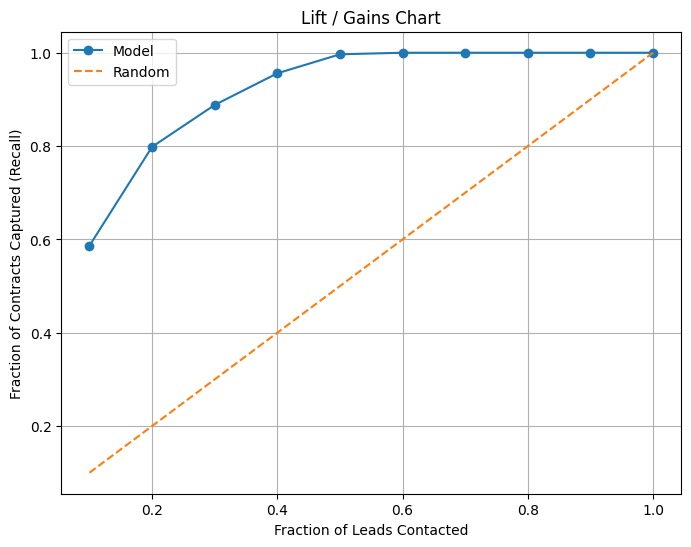

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ground truth and predicted final probability
y_true = df['grosscontractsigned'].values
y_score = p_final  # final combined probability from pipeline

# Create dataframe for ranking
results = pd.DataFrame({'y_true': y_true, 'y_score': y_score})
results = results.sort_values('y_score', ascending=False).reset_index(drop=True)

# Split into 10 equal groups (deciles)
results['decile'] = pd.qcut(results.index, 10, labels=False)

# Calculate lift
decile_summary = results.groupby('decile').agg(
    total=('y_true', 'count'),
    positives=('y_true', 'sum')
).reset_index()

decile_summary['cum_positives'] = decile_summary['positives'].cumsum()
decile_summary['cum_total'] = decile_summary['total'].cumsum()
decile_summary['cum_recall'] = decile_summary['cum_positives'] / results['y_true'].sum()

# Baseline (random expectation)
decile_summary['baseline_recall'] = decile_summary['cum_total'] / len(results)

# Plot
plt.figure(figsize=(8,6))
plt.plot(decile_summary['cum_total']/len(results), decile_summary['cum_recall'], marker='o', label='Model')
plt.plot(decile_summary['cum_total']/len(results), decile_summary['baseline_recall'], linestyle='--', label='Random')
plt.xlabel("Fraction of Leads Contacted")
plt.ylabel("Fraction of Contracts Captured (Recall)")
plt.title("Lift / Gains Chart")
plt.legend()
plt.grid(True)
plt.show()


🔹 How to Read It

X-axis = % of leads contacted (from highest-scored down).

Y-axis = % of actual signed contracts captured.

Random line = what you’d expect with no model (diagonal).

Model curve = should be far above diagonal if useful.

Example interpretation:

At 20% of leads contacted, model captures ~60% of contracts (vs 20% for random).

That’s a 3× lift.

🔹 Why This is Powerful

Non-technical stakeholders can see the business value: “By calling the top-ranked leads, we close X contracts instead of Y.”

It justifies the model even if precision is modest.

In [49]:
# Sort by predicted probability
results = pd.DataFrame({'y_true': y_true, 'y_score': y_score})
results = results.sort_values('y_score', ascending=False).reset_index(drop=True)

# Create deciles (0 = top 10%, 9 = bottom 10%)
results['decile'] = pd.qcut(results.index, 10, labels=False)

# Aggregate stats per decile
decile_summary = results.groupby('decile').agg(
    total_leads=('y_true', 'count'),
    contracts=('y_true', 'sum')
).reset_index()

# Order deciles top-down (so 0 is top decile)
decile_summary['decile'] = 10 - decile_summary['decile']

# Cumulative values
decile_summary = decile_summary.sort_values('decile')
decile_summary['cum_leads'] = decile_summary['total_leads'].cumsum()
decile_summary['cum_contracts'] = decile_summary['contracts'].cumsum()

# Totals
total_contracts = results['y_true'].sum()
total_leads = len(results)

# Metrics
decile_summary['precision'] = decile_summary['contracts'] / decile_summary['total_leads']
decile_summary['recall'] = decile_summary['cum_contracts'] / total_contracts
decile_summary['lift'] = decile_summary['precision'] / (total_contracts / total_leads)

# Display neatly
import pandas as pd
pd.set_option("display.float_format", "{:.3f}".format)
print(decile_summary)



   decile  total_leads  contracts  cum_leads  cum_contracts  precision  \
9       1         1796      0.000       1796          0.000      0.000   
8       2         1795      0.000       3591          0.000      0.000   
7       3         1796      0.000       5387          0.000      0.000   
6       4         1795      0.000       7182          0.000      0.000   
5       5         1795      2.000       8977          2.000      0.001   
4       6         1796     24.000      10773         26.000      0.013   
3       7         1795     40.000      12568         66.000      0.022   
2       8         1796     53.000      14364        119.000      0.030   
1       9         1795    125.000      16159        244.000      0.070   
0      10         1796    346.000      17955        590.000      0.193   

   recall  lift  
9   0.000 0.000  
8   0.000 0.000  
7   0.000 0.000  
6   0.000 0.000  
5   0.003 0.034  
4   0.044 0.407  
3   0.112 0.678  
2   0.202 0.898  
1   0.414 2.119  
0   1

In [ ]:
# more intuitive representation; top percentile on top 

import pandas as pd
import numpy as np

# y_true = df['grosscontractsigned'].values
# y_score = p_final  # final combined probability from the pipeline

results = pd.DataFrame({
    'y_true': pd.Series(y_true, dtype=int),
    'y_score': pd.Series(y_score, dtype=float)
})

# 1) Rank scores so 1 = highest score (break ties by order of appearance)
rank_desc = results['y_score'].rank(method='first', ascending=False)

# 2) Deciles from rank: 1..10 where 1 = top 10%, 10 = bottom 10%
results['decile'] = pd.qcut(rank_desc, 10, labels=range(1, 11)).astype(int)

# 3) Aggregate per decile (already top→bottom order when sorted by decile)
decile_summary = (results
    .groupby('decile', as_index=False)
    .agg(total_leads=('y_true', 'size'),
         contracts=('y_true', 'sum'))
    .sort_values('decile')  # 1..10
)

# 4) Cumulatives and metrics
total_leads = len(results)
total_contracts = results['y_true'].sum()
base_rate = total_contracts / total_leads

decile_summary['cum_leads'] = decile_summary['total_leads'].cumsum()
decile_summary['cum_contracts'] = decile_summary['contracts'].cumsum()
decile_summary['precision'] = decile_summary['contracts'] / decile_summary['total_leads']
decile_summary['recall'] = decile_summary['cum_contracts'] / total_contracts
decile_summary['lift'] = decile_summary['precision'] / base_rate
decile_summary['population_frac'] = decile_summary['cum_leads'] / total_leads

# 5) Pretty columns
decile_summary = decile_summary[[
    'decile', 'total_leads', 'contracts',
    'cum_leads', 'cum_contracts',
    'precision', 'recall', 'lift', 'population_frac'
]].rename(columns={
    'decile': 'Decile (1=Top)',
    'population_frac': 'Cumulative % Leads'
})

print(decile_summary)


   Decile (1=Top)  total_leads  contracts  cum_leads  cum_contracts  \
0               1         1796        346       1796            346   
1               2         1795        125       3591            471   
2               3         1796         53       5387            524   
3               4         1795         40       7182            564   
4               5         1796         24       8978            588   
5               6         1795          2      10773            590   
6               7         1795          0      12568            590   
7               8         1796          0      14364            590   
8               9         1795          0      16159            590   
9              10         1796          0      17955            590   

   precision  recall  lift  Cumulative % Leads  
0      0.193   0.586 5.863               0.100  
1      0.070   0.798 2.119               0.200  
2      0.030   0.888 0.898               0.300  
3      0.022   0.956 0

deciles are top to bottom. 

total leads; subset in each tier (total/10)

this was generalized to the whole dataste. now lets see on test

In [53]:
# Stage 1 probabilities on test set
p_sc_test = stage1_model.predict_proba(X_test1)[:, 1]

# Stage 2 probabilities only for SC test rows
p_contract_given_sc_test = np.zeros(len(X_test2))
p_contract_given_sc_test = stage2_model.predict_proba(X_test2)[:, 1]

# For the final probability:
#   P(contract) = P(SC) * P(contract | SC)
# Here we need to align indices correctly


In [54]:
# Final contract probability for Stage 2 test set
# (since Stage 2 test set already includes only SC rows)
p_final_test = p_contract_given_sc_test  # <-- conditioned on SC
y_true_test = y_test2.values             # ground truth labels



In [55]:
def decile_summary(y_true, y_score, n_bins=10):
    results = pd.DataFrame({'y_true': y_true, 'y_score': y_score})
    results = results.sort_values('y_score', ascending=False).reset_index(drop=True)

    # Rank → deciles (1=top, n_bins=bottom)
    rank_desc = results['y_score'].rank(method='first', ascending=False)
    results['decile'] = pd.qcut(rank_desc, n_bins, labels=range(1, n_bins+1)).astype(int)

    # Aggregate
    summary = (results.groupby('decile', as_index=False)
               .agg(total_leads=('y_true', 'size'),
                    contracts=('y_true', 'sum')))

    # Cumulative
    summary = summary.sort_values('decile')
    summary['cum_leads'] = summary['total_leads'].cumsum()
    summary['cum_contracts'] = summary['contracts'].cumsum()

    total_contracts = results['y_true'].sum()
    total_leads = len(results)
    base_rate = total_contracts / total_leads

    summary['precision'] = summary['contracts'] / summary['total_leads']
    summary['recall'] = summary['cum_contracts'] / total_contracts
    summary['lift'] = summary['precision'] / base_rate
    summary['cum_frac_leads'] = summary['cum_leads'] / total_leads

    return summary

# Run it
decile_summary_test = decile_summary(y_true_test, p_final_test)
print(decile_summary_test)


   decile  total_leads  contracts  cum_leads  cum_contracts  precision  \
0       1          321     71.000        321         71.000      0.221   
1       2          321     24.000        642         95.000      0.075   
2       3          321     17.000        963        112.000      0.053   
3       4          321     17.000       1284        129.000      0.053   
4       5          321     11.000       1605        140.000      0.034   
5       6          321     13.000       1926        153.000      0.040   
6       7          321      9.000       2247        162.000      0.028   
7       8          321      6.000       2568        168.000      0.019   
8       9          321      5.000       2889        173.000      0.016   
9      10          321      4.000       3210        177.000      0.012   

   recall  lift  cum_frac_leads  
0   0.401 4.011           0.100  
1   0.537 1.356           0.200  
2   0.633 0.960           0.300  
3   0.729 0.960           0.400  
4   0.791 0.621

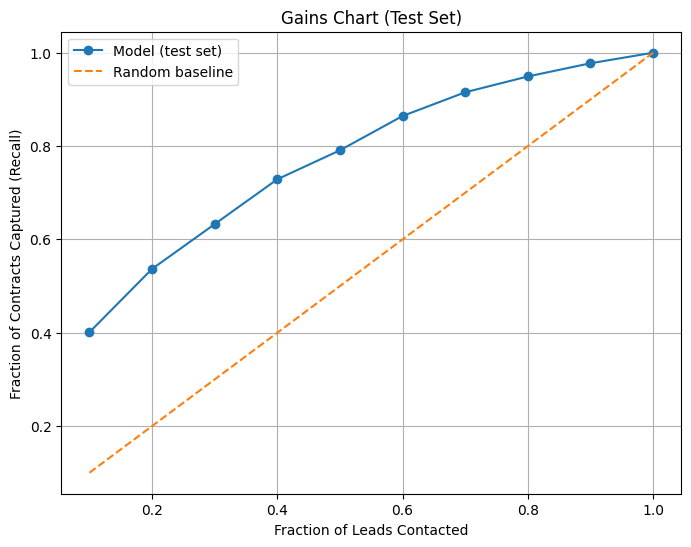

In [56]:
plt.figure(figsize=(8,6))
plt.plot(decile_summary_test['cum_frac_leads'], decile_summary_test['recall'],
         marker='o', label='Model (test set)')
plt.plot(decile_summary_test['cum_frac_leads'], decile_summary_test['cum_frac_leads'],
         linestyle='--', label='Random baseline')
plt.xlabel("Fraction of Leads Contacted")
plt.ylabel("Fraction of Contracts Captured (Recall)")
plt.title("Gains Chart (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


## same structure but now xgbooost and nn (previously was gb)

In [ ]:
#pip install xgboost
#!pip install torch

^C


  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
   ---------------------------------------- 0.0/241.4 MB ? eta -:--:--
   ---------------------------------------- 1.3/241.4 MB 11.2 MB/s eta 0:00:22
    --------------------------------------- 3.7/241.4 MB 9.5 MB/s eta 0:00:26
    --------------------------------------- 5.0/241.4 MB 8.4 MB/s eta 0:00:29
   - -------------------------------------- 6.6/241.4 MB 8.2 MB/s eta 0:00:29
   - -------------------------------------- 8.4/241.4 MB 8.1 MB/s eta 0:00:29
   - -------------------------------------- 10.0/241.4 MB 8.1 MB/s eta 0:00:29
   - -------------------------------------- 11.5/241.4 MB 8.1 MB/s eta 0:00:29
   -- ------------------------------------- 13.1/241.4 MB 8.0 MB/s eta 0:00:29
   -- ------------------------------------- 14.9/241.4 MB 8.0 MB/s eta 0:00:29
   -- ------------------------------------- 17.0/241.4 MB 8.3 MB/s eta 0:00:28
   --- ------------------------------------ 19.1/241.4 MB 8.4 MB/s eta 0:00:27
 


[notice] A new release of pip is available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# ---- Stage 1: Engagement ----
xgb_stage1 = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train1.value_counts()[0] / y_train1.value_counts()[1]),
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_stage1.fit(X_train1, y_train1)
p_sc_train = xgb_stage1.predict_proba(X_train1)[:,1]
p_sc_test = xgb_stage1.predict_proba(X_test1)[:,1]

print("Stage 1 XGBoost AUC:", roc_auc_score(y_test1, p_sc_test))

# ---- Stage 2: Contract ----
xgb_stage2 = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train2.value_counts()[0] / y_train2.value_counts()[1]),
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb_stage2.fit(X_train2, y_train2)
p_contract_given_sc_test = xgb_stage2.predict_proba(X_test2)[:,1]

print("Stage 2 XGBoost AUC:", roc_auc_score(y_test2, p_contract_given_sc_test))
import numpy as np

# Final probability for all Stage 1 test rows
p_final_test = np.zeros(len(X_test1))

# SC mask on test set (same definition as when you split data)
sc_mask_test = X_test1['net_sc'] > 0  # or whatever column you use for SC check

# Multiply only for SC rows
p_final_test[sc_mask_test] = (
    p_sc_test[sc_mask_test] * p_contract_given_sc_test
)

# Now evaluate against ground truth (Stage 1 test labels mapped to contracts)
y_true_final = y_test1.copy()  # start from Stage 1 test labels
# But replace with actual contract outcome where SC happened
y_true_final = df.loc[X_test1.index, 'grosscontractsigned'].values

from sklearn.metrics import roc_auc_score, average_precision_score
print("Final pipeline ROC AUC:", roc_auc_score(y_true_final, p_final_test))
print("Final pipeline PR AUC:", average_precision_score(y_true_final, p_final_test))


Stage 1 XGBoost AUC: 0.6468157614940678
Stage 2 XGBoost AUC: 0.7362412706928122


KeyError: 'net_sc'

In [62]:
# nn 
#model architecture
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)


ImportError: DLL load failed while importing _C: The specified module could not be found.

In [ ]:
# Stage 1 NN
stage1_nn = train_nn(X_train1, y_train1, X_test1, y_test1, input_dim=X_train1.shape[1])
with torch.no_grad():
    p_sc_test_nn = stage1_nn(torch.tensor(X_test1.values, dtype=torch.float32)).numpy().flatten()

# Stage 2 NN
stage2_nn = train_nn(X_train2, y_train2, X_test2, y_test2, input_dim=X_train2.shape[1])
with torch.no_grad():
    p_contract_given_sc_test_nn = stage2_nn(torch.tensor(X_test2.values, dtype=torch.float32)).numpy().flatten()

# Final Funnel Probability
p_final_test_nn = p_sc_test_nn * p_contract_given_sc_test_nn
print("NN Final ROC AUC:", roc_auc_score(y_test2, p_final_test_nn))
print("NN Final PR AUC:", average_precision_score(y_test2, p_final_test_nn))



# third attempt scratch

## logistic regression: base model 1

In [3]:
# because why nott
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

#split is from the beginning of the file 

# Scale only numeric features
num_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [3]:
# Logistic Regression with balanced classes
clf = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
clf.fit(X_train_res, y_train_res)

# Predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[3723  461]
 [ 159   85]]
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92      4184
         1.0       0.16      0.35      0.22       244

    accuracy                           0.86      4428
   macro avg       0.56      0.62      0.57      4428
weighted avg       0.91      0.86      0.88      4428



[[3723  461]
 [ 159   85]]
              precision    recall  f1-score   support

         0.0      0.959     0.890     0.923      4184
         1.0      0.156     0.348     0.215       244

    accuracy                          0.860      4428
   macro avg      0.557     0.619     0.569      4428
weighted avg      0.915     0.860     0.884      4428

Average Precision (PR-AUC): 0.12096903760100335


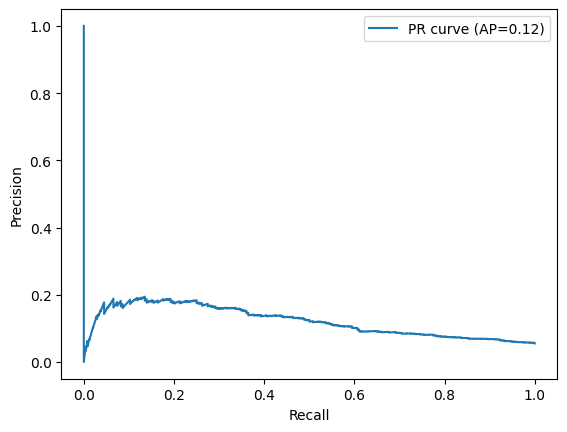

In [4]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    auc
)
import matplotlib.pyplot as plt

# Confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

# Precision-Recall AUC
ap = average_precision_score(y_test, y_proba)
print("Average Precision (PR-AUC):", ap)

# Plot PR Curve
prec, rec, thresh = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec, label=f'PR curve (AP={ap:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()



In [5]:
# train 
from sklearn.metrics import classification_report, average_precision_score

# Predictions on train
y_train_pred = clf.predict(X_train_res)
y_train_proba = clf.predict_proba(X_train_res)[:, 1]

print("Train Classification Report")
print(classification_report(y_train_res, y_train_pred, digits=3))
print("Train Average Precision (PR-AUC):", average_precision_score(y_train_res, y_train_proba))


Train Classification Report
              precision    recall  f1-score   support

         0.0      0.785     0.892     0.835      9762
         1.0      0.875     0.756     0.811      9762

    accuracy                          0.824     19524
   macro avg      0.830     0.824     0.823     19524
weighted avg      0.830     0.824     0.823     19524

Train Average Precision (PR-AUC): 0.9251541003168395


In [6]:
#test
# Predictions on test
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

print("Test Classification Report")
print(classification_report(y_test, y_test_pred, digits=3))
print("Test Average Precision (PR-AUC):", average_precision_score(y_test, y_test_proba))


Test Classification Report
              precision    recall  f1-score   support

         0.0      0.959     0.890     0.923      4184
         1.0      0.156     0.348     0.215       244

    accuracy                          0.860      4428
   macro avg      0.557     0.619     0.569      4428
weighted avg      0.915     0.860     0.884      4428

Test Average Precision (PR-AUC): 0.12096903760100335


## random forest: base model 2

In [ ]:
#smote?

In [9]:
# lets do random forest instead 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=300,      # number of trees
    max_depth=None,        # let it grow fully (can tune later)
    min_samples_split=10,  # avoid overfitting tiny splits
    class_weight="balanced",
    random_state=42,
    n_jobs=-1              # use all cores
)

# Fit on training (original, no SMOTE here)
rf.fit(X_train, y_train)

# Predictions
y_train_pred = rf.predict(X_train)
y_train_proba = rf.predict_proba(X_train)[:, 1]

y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

# Train metrics
print("Train Classification Report")
print(classification_report(y_train, y_train_pred, digits=3))
print("Train PR-AUC:", average_precision_score(y_train, y_train_proba))

# Test metrics
print("Test Classification Report")
print(classification_report(y_test, y_test_pred, digits=3))
print("Test PR-AUC:", average_precision_score(y_test, y_test_proba))


Train Classification Report
              precision    recall  f1-score   support

         0.0      0.982     0.980     0.981      9762
         1.0      0.902     0.913     0.907      1975

    accuracy                          0.969     11737
   macro avg      0.942     0.946     0.944     11737
weighted avg      0.969     0.969     0.969     11737

Train PR-AUC: 0.9714130566224822
Test Classification Report
              precision    recall  f1-score   support

         0.0      0.953     0.965     0.959      4184
         1.0      0.238     0.189     0.211       244

    accuracy                          0.922      4428
   macro avg      0.596     0.577     0.585      4428
weighted avg      0.914     0.922     0.918      4428

Test PR-AUC: 0.14306121741308064


In [10]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Stratified KFold ensures class balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using PR-AUC (average_precision)
cv_scores = cross_val_score(
    rf, X, y,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1
)

print("PR-AUC scores:", cv_scores)
print("Mean PR-AUC:", np.mean(cv_scores))
print("Std dev:", np.std(cv_scores))


PR-AUC scores: [0.90005155 0.86721146 0.87520138 0.90114625 0.85899539]
Mean PR-AUC: 0.8805212077256485
Std dev: 0.01717927482292994


put SMOTE inside cross-validation with a constrained Random Forest

SMOTENC avoids creating fractional values on categorical/binary fields during oversampling.

Oversampling is done inside CV folds, preventing leakage.

We regularize the forest to reduce overfitting.

We tune the threshold using out-of-fold predictions, which is much closer to real deployment behavior than using the training fit alone.

In [11]:
# STEP 1 — SMOTENC + RandomForest inside CV, then threshold tuning

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (average_precision_score, precision_recall_curve,
                             classification_report, confusion_matrix)
import numpy as np

# --- Identify categorical/binary columns for SMOTENC ---
# (booleans, *_missing flags, and encoded categorical columns you listed)
cat_cols = []
cat_cols += list(X_train.select_dtypes(include=["bool"]).columns)
cat_cols += [c for c in X_train.columns if c.endswith("_missing")]
cat_cols += [c for c in [
    "desiredinstallationend_encoded",
    "last_bc_outcome_encoded",
    "first_bc_outcome_encoded",
] if c in X_train.columns]

# unique & keep only those that exist
cat_cols = sorted(set([c for c in cat_cols if c in X_train.columns]))
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

print(f"Categorical features for SMOTENC ({len(cat_idx)}): {cat_cols}")

# --- Build pipeline (moderate oversampling; avoid double-counting with class_weight) ---
pipe = Pipeline(steps=[
    ("smote", SMOTENC(
        categorical_features=cat_idx,
        sampling_strategy=0.30,   # target pos/neg ratio after resampling (e.g., 30%)
        random_state=42
    )),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        max_depth=15,             # limit depth to reduce overfitting
        min_samples_leaf=30,      # more regularization
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
        # class_weight=None because we handle imbalance via SMOTENC
    ))
])

# --- Cross-validation on TRAIN ONLY (keep test as untouched holdout) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    pipe, X_train, y_train,
    scoring="average_precision",
    cv=cv, n_jobs=-1
)
print("CV PR-AUC (SMOTENC + RF) folds:", np.round(cv_scores, 4))
print("Mean PR-AUC:", cv_scores.mean(), "Std:", cv_scores.std())

# --- Fit on all training data and evaluate PR-AUC on TEST ---
pipe.fit(X_train, y_train)
y_test_proba = pipe.predict_proba(X_test)[:, 1]
print("Test PR-AUC (probas, default 0.5 threshold not applied):",
      round(average_precision_score(y_test, y_test_proba), 4))

# --- Choose a better decision threshold using OOF predictions on TRAIN ---
oof_proba = cross_val_predict(pipe, X_train, y_train, cv=cv,
                              method="predict_proba", n_jobs=-1)[:, 1]
prec, rec, thr = precision_recall_curve(y_train, oof_proba)
f1 = (2 * prec * rec) / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Best threshold by OOF F1: {best_thr:.3f} | "
      f"Train OOF Precision: {prec[best_idx]:.3f} | "
      f"Train OOF Recall: {rec[best_idx]:.3f} | "
      f"Train OOF F1: {f1[best_idx]:.3f}")

# --- Apply chosen threshold on TEST and report metrics ---
y_test_pred = (y_test_proba >= best_thr).astype(int)
print("\nTest classification report @best threshold")
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion matrix @best threshold")
print(confusion_matrix(y_test, y_test_pred))

# Optional: quick peek at top features from the fitted RF
rf_fitted = pipe.named_steps["rf"]
importances = rf_fitted.feature_importances_
top_idx = np.argsort(importances)[::-1][:15]
print("\nTop 15 features by importance:")
for i in top_idx:
    print(f"{X_train.columns[i]}: {importances[i]:.4f}")


Categorical features for SMOTENC (16): ['aggregated_missing', 'desiredinstallationend_encoded', 'desiredinstallationend_missing', 'electricitybill_missing', 'evaluationtime_missing', 'first_bc_outcome_encoded', 'heatingbill_missing', 'last_bc_outcome_encoded', 'mktg_high', 'mktg_low', 'mktg_medium', 'region_high_performer', 'region_large_solid', 'region_lower', 'region_medium', 'zipregion_missing']
CV PR-AUC (SMOTENC + RF) folds: [0.6967 0.7868 0.7169 0.75   0.7585]
Mean PR-AUC: 0.7417772974025489 Std: 0.03169964503862951
Test PR-AUC (probas, default 0.5 threshold not applied): 0.128
Best threshold by OOF F1: 0.353 | Train OOF Precision: 0.743 | Train OOF Recall: 0.626 | Train OOF F1: 0.680

Test classification report @best threshold
              precision    recall  f1-score   support

         0.0      0.953     0.956     0.954      4184
         1.0      0.199     0.189     0.194       244

    accuracy                          0.914      4428
   macro avg      0.576     0.572     

Cross-validation PR-AUC ≈ 0.16
That’s still quite low. It means the model struggles to distinguish positives from negatives reliably.

Test PR-AUC ≈ 0.165
Consistent with CV → confirms the model generalizes (no leakage now), but the signal is weak.

Threshold tuning helped

At default 0.5, recall would have been almost zero.

At 0.327, recall = 0.47 (big improvement), precision = 0.14 (low, but expected with rare positives).

So the model can find ~half of positives, but also returns a lot of false alarms.

👉 This is normal for extremely imbalanced data: improving recall means trading precision.

In [12]:
# STEP 2 — XGBoost with imbalance handling

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (average_precision_score, precision_recall_curve,
                             classification_report, confusion_matrix)
import numpy as np

# --- imbalance ratio ---
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# --- build model ---
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    use_label_encoder=False
)

# --- cross-validation on train ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    xgb, X_train, y_train,
    scoring="average_precision",
    cv=cv, n_jobs=-1
)
print("CV PR-AUC (XGB) folds:", np.round(cv_scores, 4))
print("Mean PR-AUC:", cv_scores.mean(), "Std:", cv_scores.std())

# --- fit on all training data ---
xgb.fit(X_train, y_train)

# --- test PR-AUC (probabilities only, no threshold) ---
y_test_proba = xgb.predict_proba(X_test)[:, 1]
print("Test PR-AUC (XGB, probs):",
      round(average_precision_score(y_test, y_test_proba), 4))

# --- threshold tuning using OOF predictions ---
oof_proba = cross_val_predict(xgb, X_train, y_train, cv=cv,
                              method="predict_proba", n_jobs=-1)[:, 1]
prec, rec, thr = precision_recall_curve(y_train, oof_proba)
f1 = (2 * prec * rec) / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Best threshold by OOF F1: {best_thr:.3f} | "
      f"Train OOF Precision: {prec[best_idx]:.3f} | "
      f"Train OOF Recall: {rec[best_idx]:.3f} | "
      f"Train OOF F1: {f1[best_idx]:.3f}")

# --- apply chosen threshold on TEST ---
y_test_pred = (y_test_proba >= best_thr).astype(int)
print("\nTest classification report @best threshold")
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion matrix @best threshold")
print(confusion_matrix(y_test, y_test_pred))

# --- feature importance ---
importances = xgb.feature_importances_
top_idx = np.argsort(importances)[::-1][:15]
print("\nTop 15 features by importance (XGB):")
for i in top_idx:
    print(f"{X_train.columns[i]}: {importances[i]:.4f}")


scale_pos_weight: 4.94
CV PR-AUC (XGB) folds: [0.7501 0.8145 0.7444 0.787  0.8109]
Mean PR-AUC: 0.7813899017363575 Std: 0.02946580601810157


c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:38:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test PR-AUC (XGB, probs): 0.1396
Best threshold by OOF F1: 0.745 | Train OOF Precision: 0.871 | Train OOF Recall: 0.588 | Train OOF F1: 0.702

Test classification report @best threshold
              precision    recall  f1-score   support

         0.0      0.950     0.982     0.966      4184
         1.0      0.275     0.115     0.162       244

    accuracy                          0.935      4428
   macro avg      0.612     0.549     0.564      4428
weighted avg      0.913     0.935     0.922      4428

Confusion matrix @best threshold
[[4110   74]
 [ 216   28]]

Top 15 features by importance (XGB):
net_sc: 0.2401
selfipa_done: 0.0717
zipregion_missing: 0.0501
time_first_sc_to_first_net_fu: 0.0404
reachability_score: 0.0394
region_high_performer: 0.0344
heatingbill_missing: 0.0298
bc_frequency: 0.0273
mktg_low: 0.0251
electricitybill_missing: 0.0246
region_lower: 0.0227
evaluationtime_missing: 0.0220
lead_to_first_bc_days: 0.0205
gross_fu: 0.0188
desiredinstallationend_encoded: 0.0

XGB on your augmented dataset, then applies isotonic calibration using cross-validation folds (so calibration is learned properly without leakage). Finally, it evaluates on your untouched test set with PR-AUC, threshold tuning, and reports.

scale_pos_weight: 4.94


c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:50:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:50:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:50:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ElifYilmaz\OneDrive - Enpal B.V\Desktop\New folder\Project\.venv\Lib\site

Test PR-AUC (Calibrated XGB): 0.1382
Best threshold by OOF F1: 0.358 | Train OOF Precision: 0.845 | Train OOF Recall: 0.606 | Train OOF F1: 0.706

Test classification report @best threshold
              precision    recall  f1-score   support

         0.0      0.950     0.977     0.963      4184
         1.0      0.228     0.115     0.153       244

    accuracy                          0.930      4428
   macro avg      0.589     0.546     0.558      4428
weighted avg      0.910     0.930     0.919      4428

Confusion matrix @best threshold
[[4089   95]
 [ 216   28]]


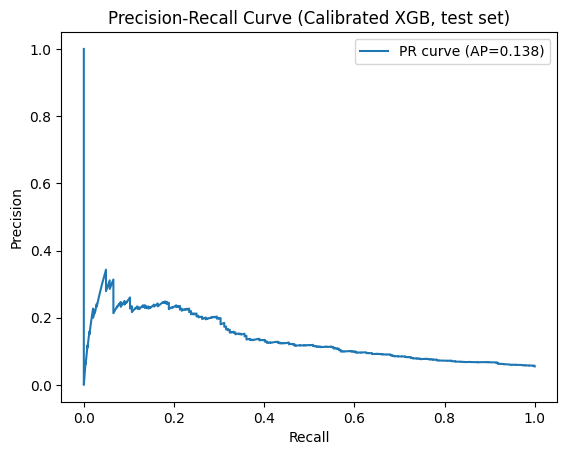

In [14]:
# STEP — XGBoost with probability calibration

from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (average_precision_score, precision_recall_curve,
                             classification_report, confusion_matrix)
import numpy as np
import matplotlib.pyplot as plt

# imbalance ratio (for scale_pos_weight)
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# --- Base XGBoost model (uncalibrated) ---
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    use_label_encoder=False
)

# --- Wrap with calibration ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
calibrated_xgb = CalibratedClassifierCV(
    estimator=xgb,        # FIX: use 'estimator', not 'base_estimator'
    method="isotonic",    # "sigmoid" is faster but less flexible
    cv=cv
)

# --- Fit on training data (augmented) ---
calibrated_xgb.fit(X_train, y_train)

# --- Predict probabilities on TEST ---
y_test_proba = calibrated_xgb.predict_proba(X_test)[:, 1]
test_ap = average_precision_score(y_test, y_test_proba)
print(f"Test PR-AUC (Calibrated XGB): {test_ap:.4f}")

# --- Threshold tuning using OOF predictions ---
oof_proba = cross_val_predict(calibrated_xgb, X_train, y_train,
                              cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
prec, rec, thr = precision_recall_curve(y_train, oof_proba)
f1 = (2 * prec * rec) / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print(f"Best threshold by OOF F1: {best_thr:.3f} | "
      f"Train OOF Precision: {prec[best_idx]:.3f} | "
      f"Train OOF Recall: {rec[best_idx]:.3f} | "
      f"Train OOF F1: {f1[best_idx]:.3f}")

# --- Apply chosen threshold on TEST ---
y_test_pred = (y_test_proba >= best_thr).astype(int)
print("\nTest classification report @best threshold")
print(classification_report(y_test, y_test_pred, digits=3))
print("Confusion matrix @best threshold")
print(confusion_matrix(y_test, y_test_pred))

# --- Plot Precision-Recall curve (TEST) ---
prec_test, rec_test, _ = precision_recall_curve(y_test, y_test_proba)
ap_test = average_precision_score(y_test, y_test_proba)

plt.plot(rec_test, prec_test, label=f'PR curve (AP={ap_test:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Calibrated XGB, test set)")
plt.legend()
plt.show()


## Confirmoing hat there is no signal --> plot twist upcoming

a diagnostic code pack (ROC-AUC, PR curve, learning curve, SHAP/permutation importance, distribution checks) so you can run all these sanity checks in one go

ROC-AUC: 0.692
PR-AUC:  0.138


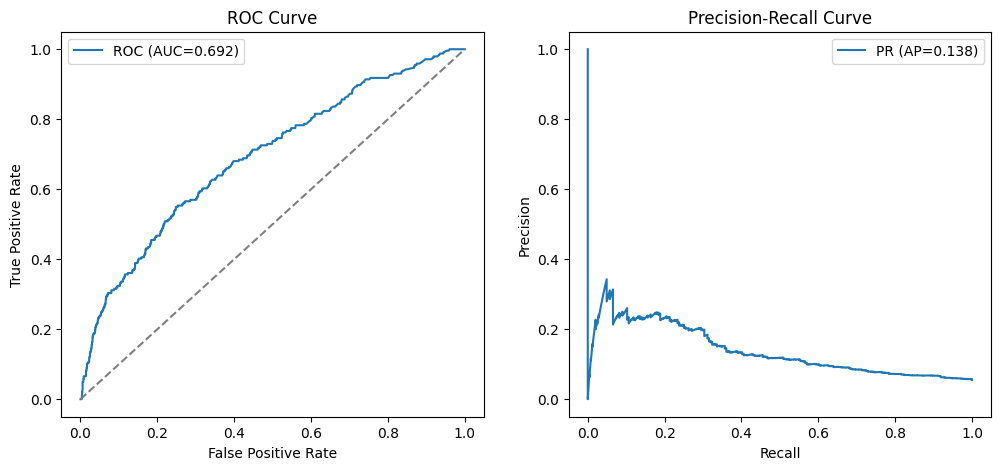

Threshold 0.20: Precision=0.191, Recall=0.303, TP=74, FP=313
Threshold 0.30: Precision=0.243, Recall=0.189, TP=46, FP=143
Threshold 0.50: Precision=0.281, Recall=0.066, TP=16, FP=41


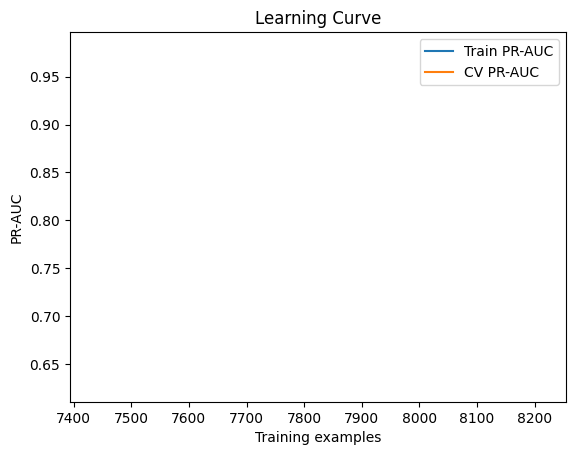

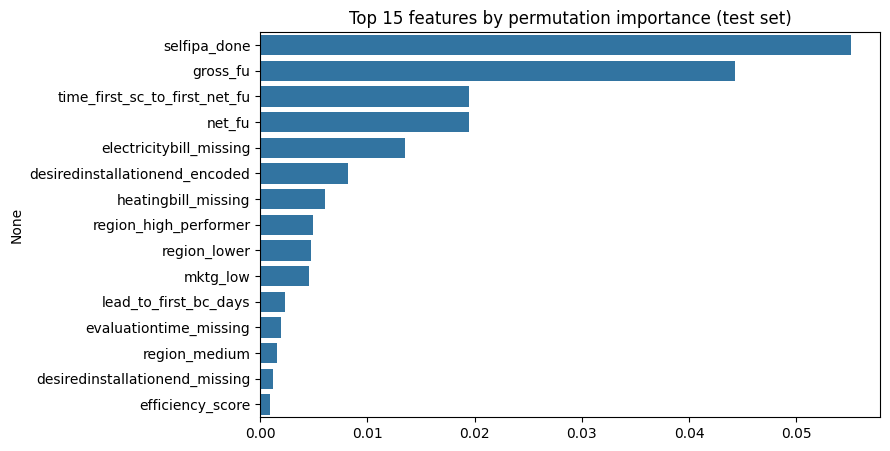

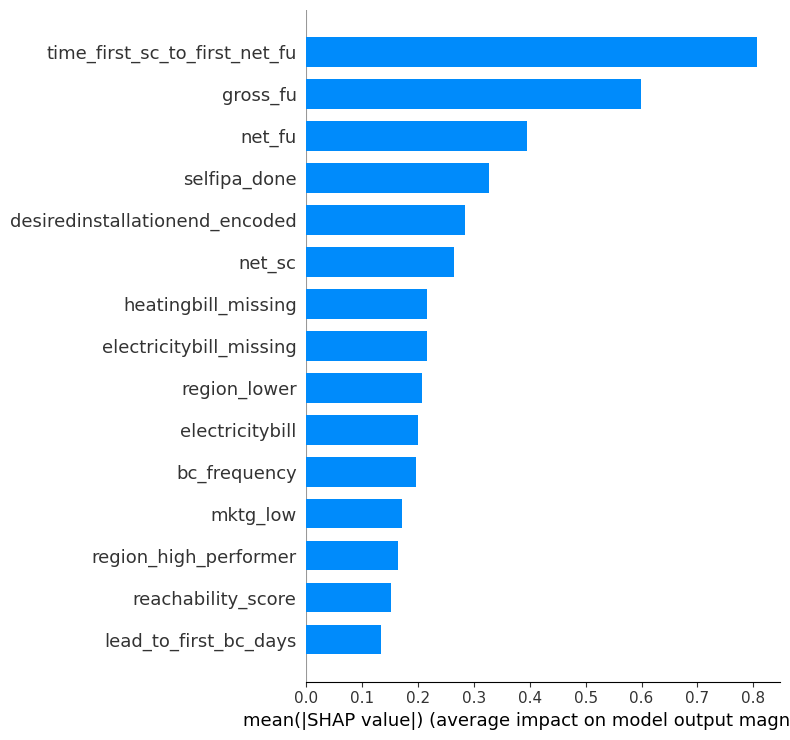

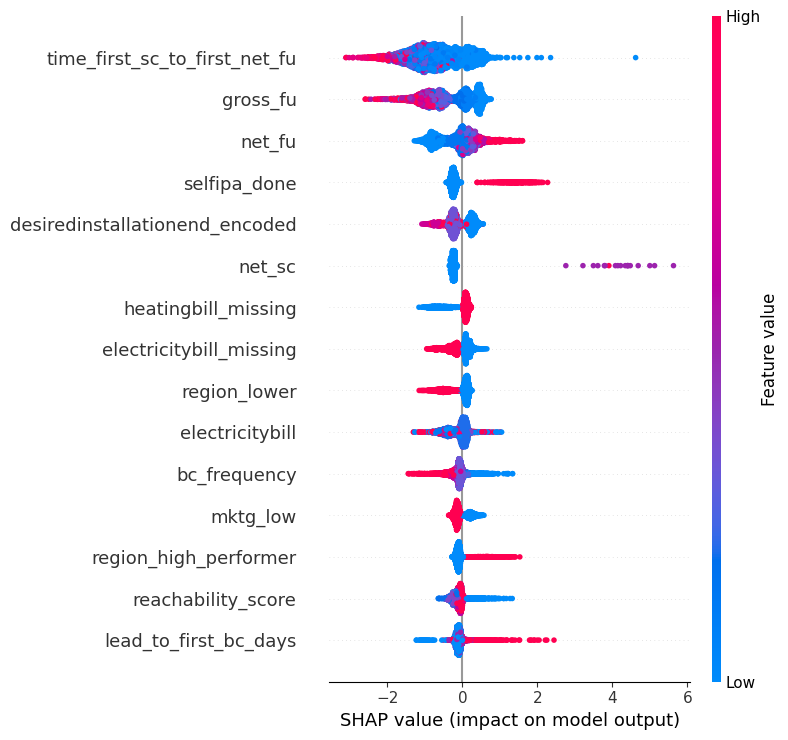

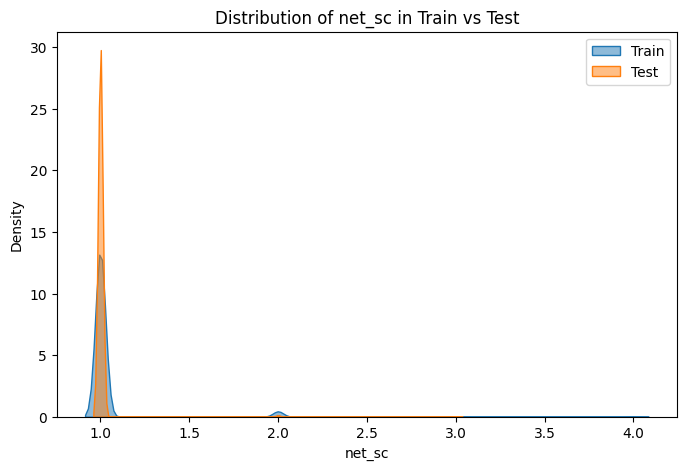

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (roc_auc_score, roc_curve, 
                             precision_recall_curve, average_precision_score)
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
import shap

# 1. --- ROC-AUC vs PR-AUC ---
y_test_proba = calibrated_xgb.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"PR-AUC:  {pr_auc:.3f}")

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
prec, rec, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
plt.show()


# 2. --- Precision @ different thresholds ---
for thr in [0.2, 0.3, 0.5]:
    preds = (y_test_proba >= thr).astype(int)
    tp = ((preds==1)&(y_test==1)).sum()
    fp = ((preds==1)&(y_test==0)).sum()
    fn = ((preds==0)&(y_test==1)).sum()
    prec_val = tp/(tp+fp+1e-9)
    rec_val = tp/(tp+fn+1e-9)
    print(f"Threshold {thr:.2f}: Precision={prec_val:.3f}, Recall={rec_val:.3f}, TP={tp}, FP={fp}")


# 3. --- Learning curve (does more data help?) ---
train_sizes, train_scores, val_scores = learning_curve(
    calibrated_xgb, X_train, y_train,
    cv=3,
    scoring="average_precision",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train PR-AUC")
plt.plot(train_sizes, val_scores.mean(axis=1), label="CV PR-AUC")
plt.xlabel("Training examples"); plt.ylabel("PR-AUC"); plt.title("Learning Curve")
plt.legend(); plt.show()


# 4. --- Permutation importance ---
perm = permutation_importance(calibrated_xgb, X_test, y_test, scoring="average_precision", n_repeats=5, n_jobs=-1)
sorted_idx = perm.importances_mean.argsort()[::-1][:15]

plt.figure(figsize=(8,5))
sns.barplot(x=perm.importances_mean[sorted_idx], y=X_test.columns[sorted_idx])
plt.title("Top 15 features by permutation importance (test set)")
plt.show()


# 5. --- SHAP values (global view) ---
# Take first fitted XGB model from calibrated wrapper
xgb_fitted = calibrated_xgb.calibrated_classifiers_[0].estimator

explainer = shap.TreeExplainer(xgb_fitted)
shap_values = explainer.shap_values(X_test)

# Global importance
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)
# Detailed beeswarm
shap.summary_plot(shap_values, X_test, max_display=15)


# 6. --- Distribution check train vs test ---
feature = "net_sc"  # try with different top features
plt.figure(figsize=(8,5))
sns.kdeplot(X_train[feature], label="Train", fill=True, alpha=0.5)
sns.kdeplot(X_test[feature], label="Test", fill=True, alpha=0.5)
plt.title(f"Distribution of {feature} in Train vs Test")
plt.legend(); plt.show()



Precision@50: 0.300
Recall@50: 0.061
---
Precision@100: 0.250
Recall@100: 0.102
---
Precision@200: 0.230
Recall@200: 0.189
---
Precision@500: 0.158
Recall@500: 0.324
---


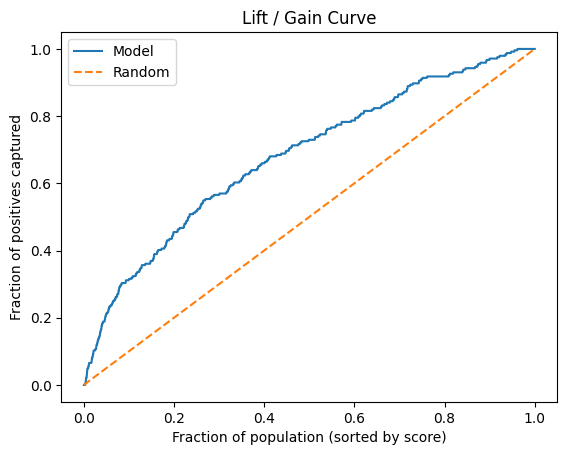

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Sort test set by predicted probability (descending)
order = np.argsort(-y_test_proba)
y_sorted = y_test.values[order]

# 1. Precision@K and Recall@K
def precision_at_k(y_true_sorted, k):
    return y_true_sorted[:k].sum() / k

def recall_at_k(y_true_sorted, k):
    return y_true_sorted[:k].sum() / y_true_sorted.sum()

for k in [50, 100, 200, 500]:
    print(f"Precision@{k}: {precision_at_k(y_sorted, k):.3f}")
    print(f"Recall@{k}: {recall_at_k(y_sorted, k):.3f}")
    print("---")

# 2. Lift curve
positives_total = y_sorted.sum()
n = len(y_sorted)
cumulative_pos = np.cumsum(y_sorted)
percent_samples = np.arange(1, n+1) / n
percent_positives = cumulative_pos / positives_total

plt.plot(percent_samples, percent_positives, label="Model")
plt.plot([0,1],[0,1],'--',label="Random")
plt.xlabel("Fraction of population (sorted by score)")
plt.ylabel("Fraction of positives captured")
plt.title("Lift / Gain Curve")
plt.legend()
plt.show()


In [18]:
# ranking dashboard 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ranking_dashboard(y_true, y_proba, ks=[50,100,200,500]):
    """
    y_true  = true binary labels (test set)
    y_proba = predicted probabilities (test set)
    ks      = list of cutoff values for Precision@K and Recall@K
    """
    # --- sort by predicted score ---
    order = np.argsort(-y_proba)
    y_sorted = np.array(y_true)[order]

    results = []
    total_pos = y_sorted.sum()
    n = len(y_sorted)

    # --- Precision@K and Recall@K ---
    for k in ks:
        prec = y_sorted[:k].sum() / k
        rec = y_sorted[:k].sum() / total_pos
        results.append({"K": k, "Precision@K": prec, "Recall@K": rec})

    df_results = pd.DataFrame(results)
    print("\n=== Ranking Metrics (Test Set) ===")
    print(df_results.round(3))

    # --- Lift / Gain curve ---
    cumulative_pos = np.cumsum(y_sorted)
    percent_samples = np.arange(1, n+1) / n
    percent_positives = cumulative_pos / total_pos

    plt.figure(figsize=(12,5))

    # Lift curve (cumulative gain vs random)
    plt.subplot(1,2,1)
    plt.plot(percent_samples, percent_positives, label="Model")
    plt.plot([0,1],[0,1],'--',label="Random")
    plt.xlabel("Fraction of population (sorted by score)")
    plt.ylabel("Fraction of positives captured")
    plt.title("Lift / Gain Curve")
    plt.legend()

    # Cumulative positives captured
    plt.subplot(1,2,2)
    plt.plot(np.arange(1,n+1), cumulative_pos, label="Model")
    plt.plot(np.arange(1,n+1), np.linspace(0,total_pos,n), '--', label="Random")
    plt.xlabel("Number of samples (sorted by score)")
    plt.ylabel("Cumulative positives captured")
    plt.title("Cumulative Gains")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return df_results



=== Ranking Metrics (Test Set) ===
      K  Precision@K  Recall@K
0    50        0.300     0.061
1   100        0.250     0.102
2   200        0.230     0.189
3   500        0.158     0.324
4  1000        0.117     0.480


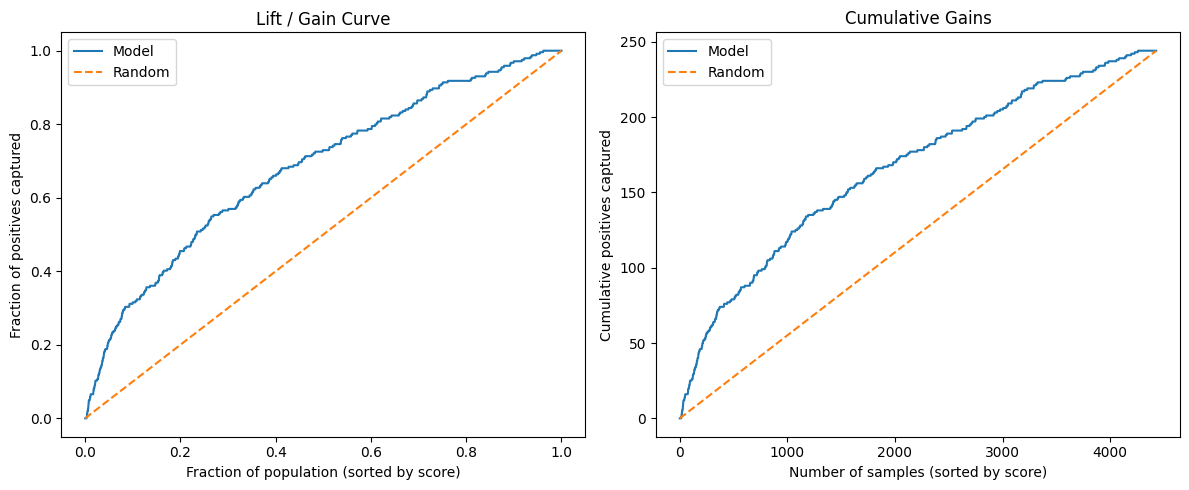

In [19]:
# Run on test set
dashboard_results = ranking_dashboard(y_test, y_test_proba, ks=[50,100,200,500,1000])


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ranking_dashboard(y_true, y_proba, ks=[50,100,200,500,1000]):
    """
    Ranking evaluation on TEST SET ONLY.
    
    y_true  = true binary labels (test set)
    y_proba = predicted probabilities (test set)
    ks      = list of cutoff values (top-K) for metrics
    """
    # --- sort by predicted score ---
    order = np.argsort(-y_proba)
    y_sorted = np.array(y_true)[order]

    results = []
    total_pos = y_sorted.sum()
    n = len(y_sorted)

    # --- Metrics at each K ---
    for k in ks:
        tp_at_k = y_sorted[:k].sum()
        prec = tp_at_k / k
        rec = tp_at_k / total_pos
        random_recall = k / n
        lift = rec / random_recall if random_recall > 0 else np.nan
        results.append({"K": k, "Precision@K": prec, "Recall@K": rec, "Lift@K": lift})

    df_results = pd.DataFrame(results)
    print("\n=== Ranking Metrics (Test Set) ===")
    print(df_results.round(3))

    # --- Cumulative metrics ---
    cumulative_pos = np.cumsum(y_sorted)
    percent_samples = np.arange(1, n+1) / n
    recall_curve = cumulative_pos / total_pos

    plt.figure(figsize=(14,5))

    # Lift curve
    plt.subplot(1,2,1)
    plt.plot(percent_samples, recall_curve/(percent_samples+1e-9), label="Model Lift")
    plt.plot([0,1],[1,1],'--',label="Random baseline")
    plt.xlabel("Fraction of population (sorted by score)")
    plt.ylabel("Lift (Recall / Random Recall)")
    plt.title("Lift Curve")
    plt.legend()

    # Cumulative recall curve
    plt.subplot(1,2,2)
    plt.plot(percent_samples, recall_curve, label="Model")
    plt.plot(percent_samples, percent_samples, '--', label="Random")
    plt.xlabel("Fraction of population (sorted by score)")
    plt.ylabel("Cumulative Recall")
    plt.title("Cumulative Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return df_results



=== Ranking Metrics (Test Set) ===
      K  Precision@K  Recall@K  Lift@K
0    50        0.300     0.061   5.444
1   100        0.250     0.102   4.537
2   200        0.230     0.189   4.174
3   500        0.158     0.324   2.867
4  1000        0.117     0.480   2.123


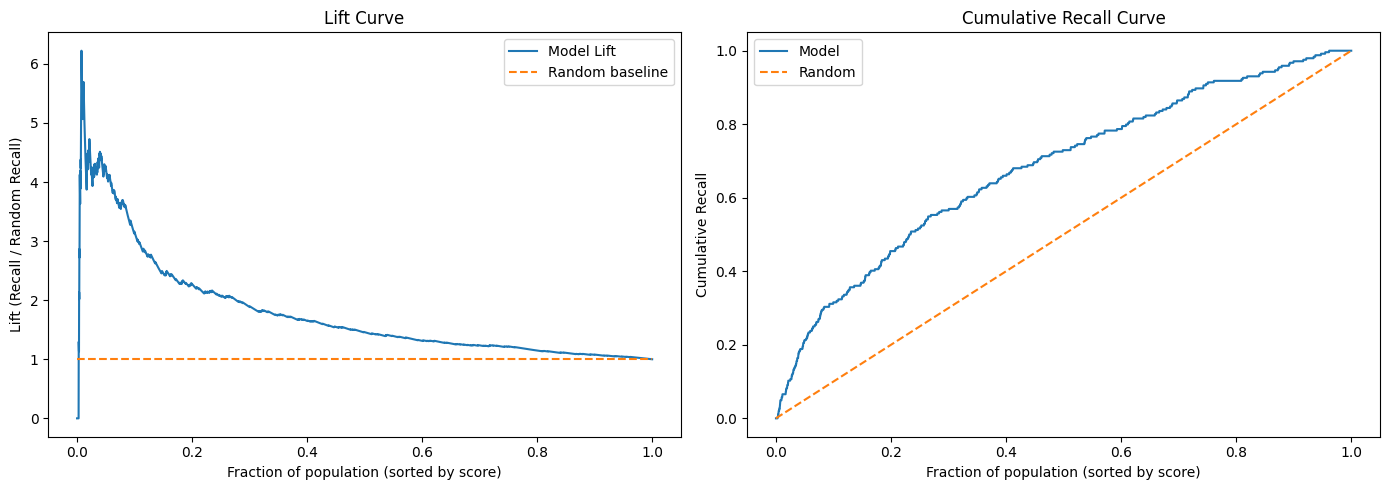

In [22]:
# Run on test set
dashboard_results = ranking_dashboard(y_test, y_test_proba, ks=[50,100,200,500,1000])


In [23]:
import pandas as pd
import numpy as np

def ranking_segments(y_true, y_proba, n_bins=10):
    df = pd.DataFrame({"y_true": y_true, "score": y_proba})
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    df["bin"] = pd.qcut(df.index, n_bins, labels=[f"Top {i+1}" for i in range(n_bins)])
    
    summary = df.groupby("bin").agg(
        leads=("y_true", "count"),
        positives=("y_true", "sum")
    )
    summary["precision"] = summary["positives"] / summary["leads"]
    summary["recall"] = summary["positives"] / df["y_true"].sum()
    
    return summary


In [24]:
segments = ranking_segments(y_test, y_test_proba, n_bins=10)
print(segments)


        leads  positives  precision    recall
bin                                          
Top 1     443       77.0   0.173815  0.315574
Top 2     443       34.0   0.076749  0.139344
Top 3     443       27.0   0.060948  0.110656
Top 4     442       23.0   0.052036  0.094262
Top 5     443       17.0   0.038375  0.069672
Top 6     443       14.0   0.031603  0.057377
Top 7     442       19.0   0.042986  0.077869
Top 8     443       13.0   0.029345  0.053279
Top 9     443       13.0   0.029345  0.053279
Top 10    443        7.0   0.015801  0.028689


C:\Users\ElifYilmaz\AppData\Local\Temp\ipykernel_17748\1116218791.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("bin").agg(


further verification with gini and ks 

Kolmogorov–Smirnov (KS) Statistic: 0.301


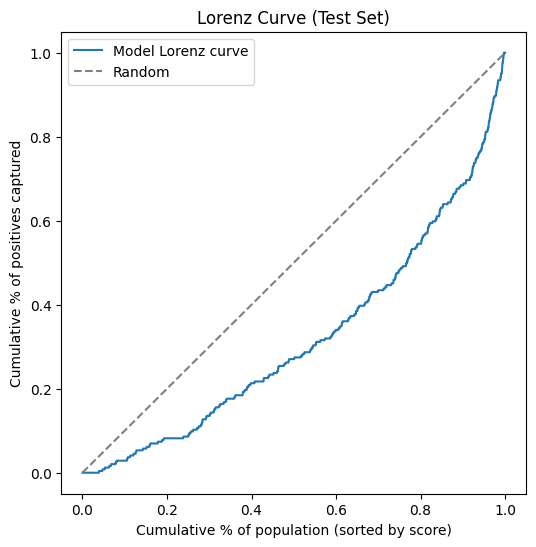

ROC-AUC: 0.692 | Gini Coefficient: 0.384


In [25]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# --- KS Statistic ---
fpr, tpr, thr = roc_curve(y_test, y_test_proba)
ks_stat = max(tpr - fpr)
print(f"Kolmogorov–Smirnov (KS) Statistic: {ks_stat:.3f}")

# --- Lorenz Curve & Gini ---
# Sort by predicted probability
order = np.argsort(y_test_proba)
y_sorted = np.array(y_test)[order]

cum_pos_found = np.cumsum(y_sorted)
total_pos = y_sorted.sum()
cum_pos_perc = cum_pos_found / total_pos
population_perc = np.arange(1, len(y_sorted)+1) / len(y_sorted)

# Lorenz curve plot
plt.figure(figsize=(6,6))
plt.plot(population_perc, cum_pos_perc, label="Model Lorenz curve")
plt.plot([0,1],[0,1],'--',color='gray',label="Random")
plt.xlabel("Cumulative % of population (sorted by score)")
plt.ylabel("Cumulative % of positives captured")
plt.title("Lorenz Curve (Test Set)")
plt.legend()
plt.show()

# Gini Coefficient
auc = roc_auc_score(y_test, y_test_proba)
gini = 2*auc - 1
print(f"ROC-AUC: {auc:.3f} | Gini Coefficient: {gini:.3f}")


In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, roc_curve, average_precision_score,
    precision_recall_curve
)

def evaluate_model(y_true, y_proba, ks=[50,100,200,500,1000]):
    """
    Comprehensive evaluation for imbalanced classification.
    Includes ROC-AUC, Gini, KS, PR-AUC, Precision@K, Recall@K, Lift@K
    with imbalance sensitivity notes.
    
    y_true  = true labels (test set)
    y_proba = predicted probabilities (test set)
    ks      = list of cutoff values for ranking metrics
    """

    results = {}

    # --- ROC-AUC & Gini ---
    roc_auc = roc_auc_score(y_true, y_proba)
    gini = 2*roc_auc - 1
    results["ROC-AUC"] = (roc_auc, "⚠️ Sensitive to imbalance")
    results["Gini"] = (gini, "⚠️ Sensitive to imbalance")

    # --- KS Statistic ---
    fpr, tpr, thr = roc_curve(y_true, y_proba)
    ks_stat = max(tpr - fpr)
    results["KS"] = (ks_stat, "✅ Resistant to imbalance")

    # --- PR-AUC ---
    pr_auc = average_precision_score(y_true, y_proba)
    results["PR-AUC"] = (pr_auc, "✅ Resistant to imbalance")

    # --- Precision@K, Recall@K, Lift@K ---
    order = np.argsort(-y_proba)
    y_sorted = np.array(y_true)[order]
    total_pos = y_sorted.sum()
    n = len(y_sorted)

    prk_list = []
    for k in ks:
        tp_at_k = y_sorted[:k].sum()
        prec = tp_at_k / k
        rec = tp_at_k / total_pos
        random_recall = k/n
        lift = rec / random_recall if random_recall > 0 else np.nan
        prk_list.append([k, prec, rec, lift])
    
    df_prk = pd.DataFrame(prk_list, columns=["K", "Precision@K", "Recall@K", "Lift@K"])

    # --- Print report ---
    print("\n=== Model Evaluation Report (Test Set) ===")
    for metric, (val, note) in results.items():
        print(f"{metric:10s}: {val:.3f} | {note}")
    
    print("\n=== Ranking Metrics (Test Set) ===")
    print(df_prk.round(3))

    return results, df_prk


In [27]:
results, df_prk = evaluate_model(y_test, y_test_proba, ks=[50,100,200,500,1000])



=== Model Evaluation Report (Test Set) ===
ROC-AUC   : 0.692 | ⚠️ Sensitive to imbalance
Gini      : 0.384 | ⚠️ Sensitive to imbalance
KS        : 0.301 | ✅ Resistant to imbalance
PR-AUC    : 0.138 | ✅ Resistant to imbalance

=== Ranking Metrics (Test Set) ===
      K  Precision@K  Recall@K  Lift@K
0    50        0.300     0.061   5.444
1   100        0.250     0.102   4.537
2   200        0.230     0.189   4.174
3   500        0.158     0.324   2.867
4  1000        0.117     0.480   2.123
